In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
data = pd.read_csv("data.csv", index_col=0)
min_value = data.iloc[:, 5:].min().min()
data = data.fillna(min_value - 1)
data.iloc[:, 5:] = data.iloc[:, 5:] + (min_value - 1)*(-1)

In [3]:
name_mac_relation = pd.read_csv("mac_name_relation.csv", index_col=0)
good_aps = name_mac_relation[name_mac_relation['ap_name'].isin( ["Guest-CentraleSupelec", "eduroam", 'stop&go', 'CD91', 'fabrique2024'])]["ap_mac"].to_list()
columns_to_maintain  = good_aps + data.columns[:5].to_list()
data = data[data.columns.intersection(columns_to_maintain)]

In [4]:
AP_columns = list(data.columns[5:])
non_AP_columns = list(data.columns[:5])
data_eduroam = data[data["room_part"] != 5]

In [5]:
#eduroam_aps = name_mac_relation[name_mac_relation['ap_name'].isin( ["fabrique2024"])]["ap_mac"].to_list()
#columns_to_maintain  = eduroam_aps + data.columns[:5].to_list()

#data_eduroam = data[data.columns.intersection(columns_to_maintain)]

In [65]:
#AP_columns = list(data_eduroam.columns[5:])
#non_AP_columns = list(data_eduroam.columns[:5])
#data_eduroam = data_eduroam[data_eduroam["room_part"] != 5]

In [6]:
len(AP_columns)

409

# Testing Models

With KNN

In [67]:
test_data = data_eduroam[data_eduroam["device_id"] == "G" ]
train_data = data_eduroam[data_eduroam["device_id"] != "G"]

In [68]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
neigh = KNeighborsClassifier(n_neighbors=2, )
neigh.fit(train_data.iloc[:,5:], train_data['room'])
predicted = neigh.predict(test_data.iloc[:,5:])
ground_truth = test_data["room"].to_numpy()
np.sum(predicted == ground_truth)/len(ground_truth)


0.8326693227091634

G: from 0.888 to 0.887

R: from 0.876 to 0.879

V: from 0.983 to 0.973

With Lockin

In [41]:
test_data = data[data["device_id"] == "V" ]
train_data = data[data["device_id"] != "V"]

In [42]:
from rbf import TLoc

columns_to_train = [train_data.columns[1]] + list(train_data.columns[5:])
tloc = TLoc(train_data[columns_to_train])
tloc.train()

accuracy, prediction, ground_truth = tloc.pred(test_data)
accuracy

0.9734207172765338

G: from 0.923 to 0.900

R: from 0.891 to 0.889

V: from 0.973 to 0.961

# Clustering

In [7]:
from tslearn.clustering import TimeSeriesKMeans


c:\Users\merte\miniconda3\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [8]:
data_to_cluster = data[data["device_id"] == "C"][AP_columns].transpose()

In [9]:
km = TimeSeriesKMeans(n_clusters=80, verbose=True, random_state=42)
y_pred = km.fit_predict(data_to_cluster)

27614.526 --> 16730.192 --> 16716.144 --> 16710.060 --> 16710.060 --> 


In [10]:
data_to_cluster['cluster'] = y_pred

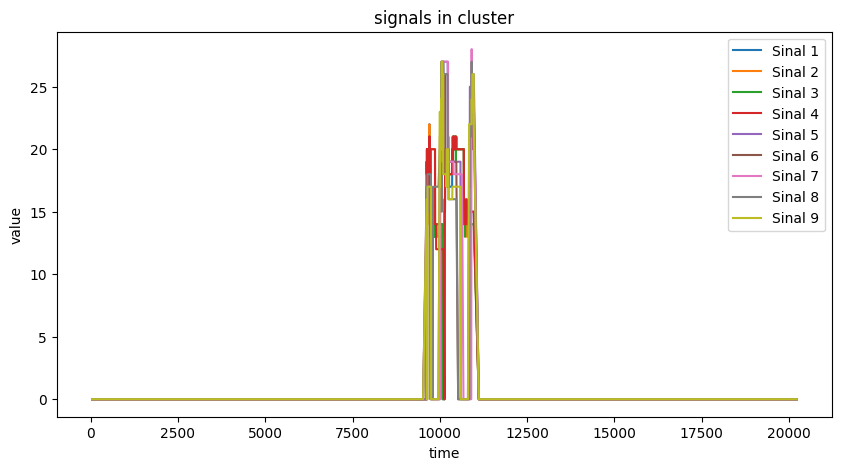

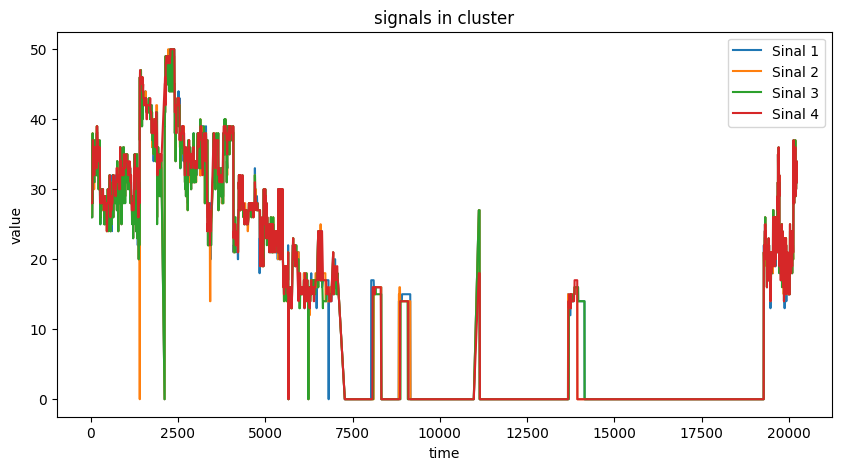

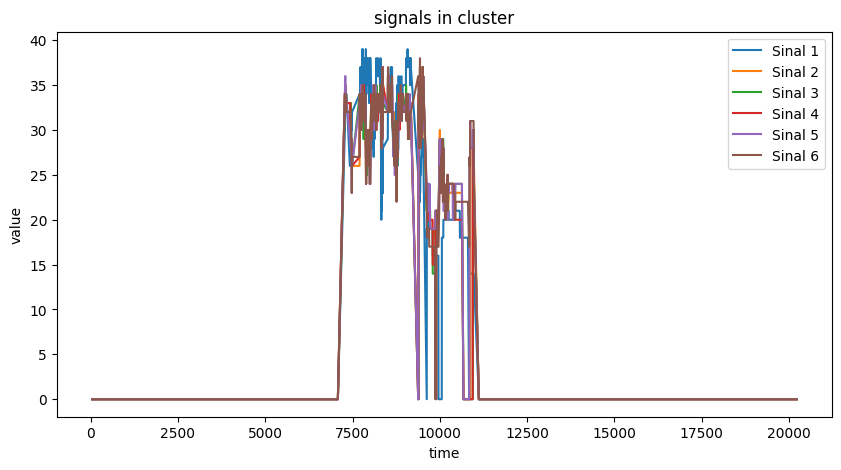

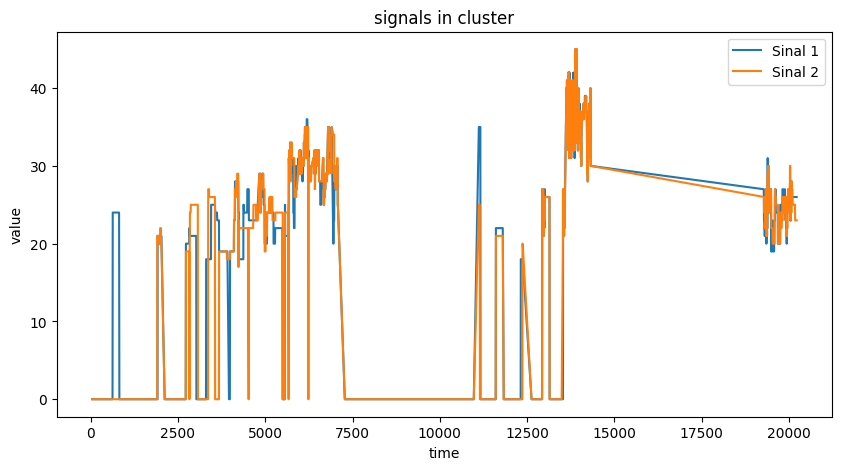

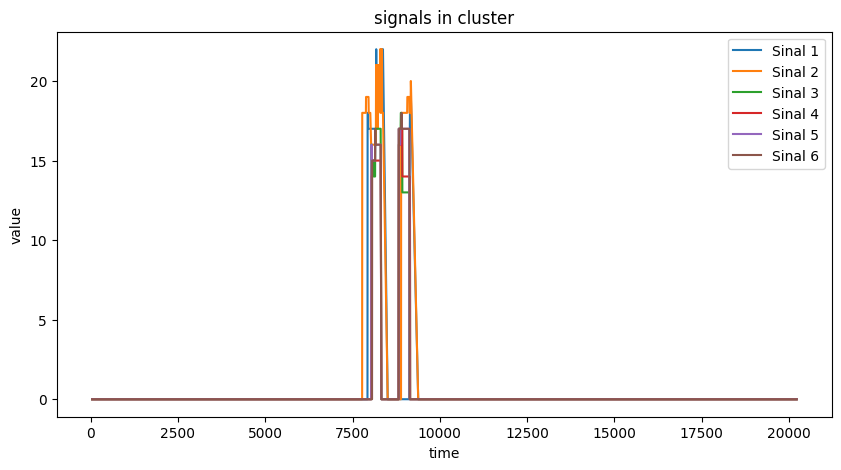

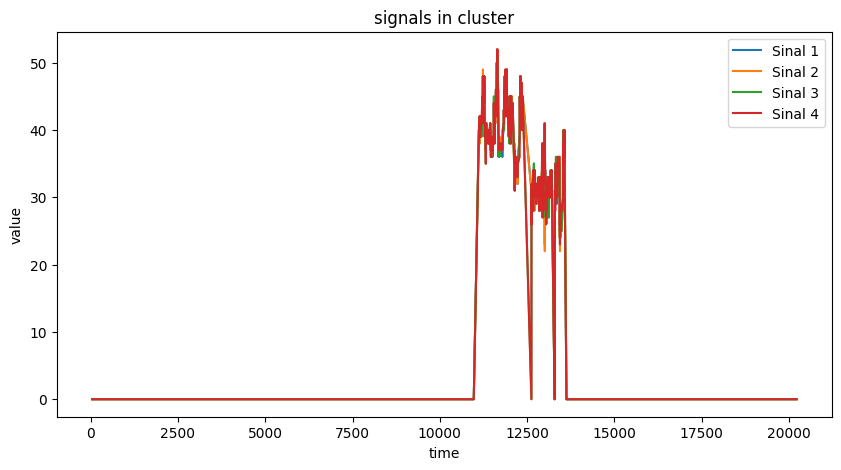

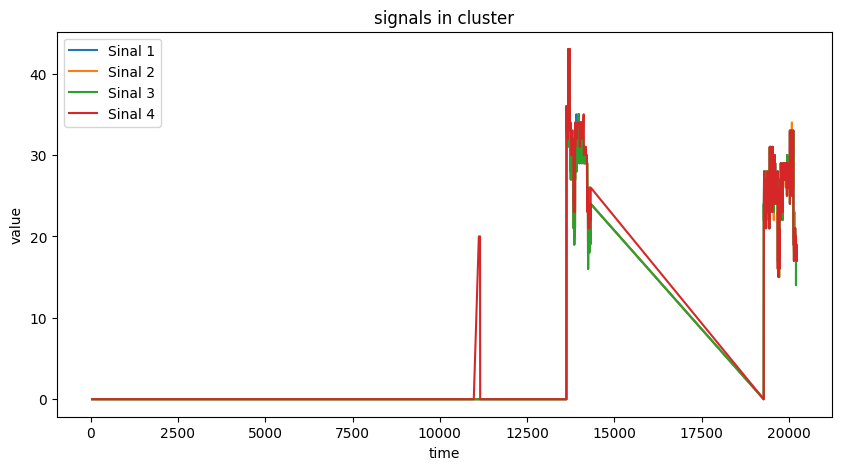

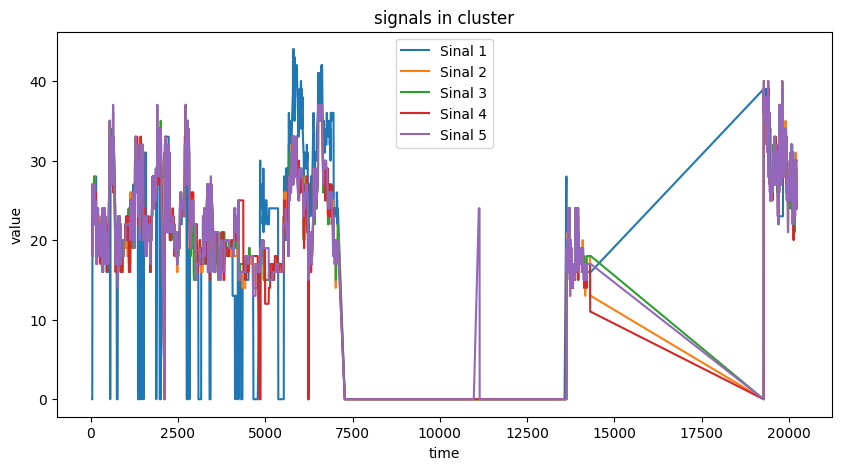

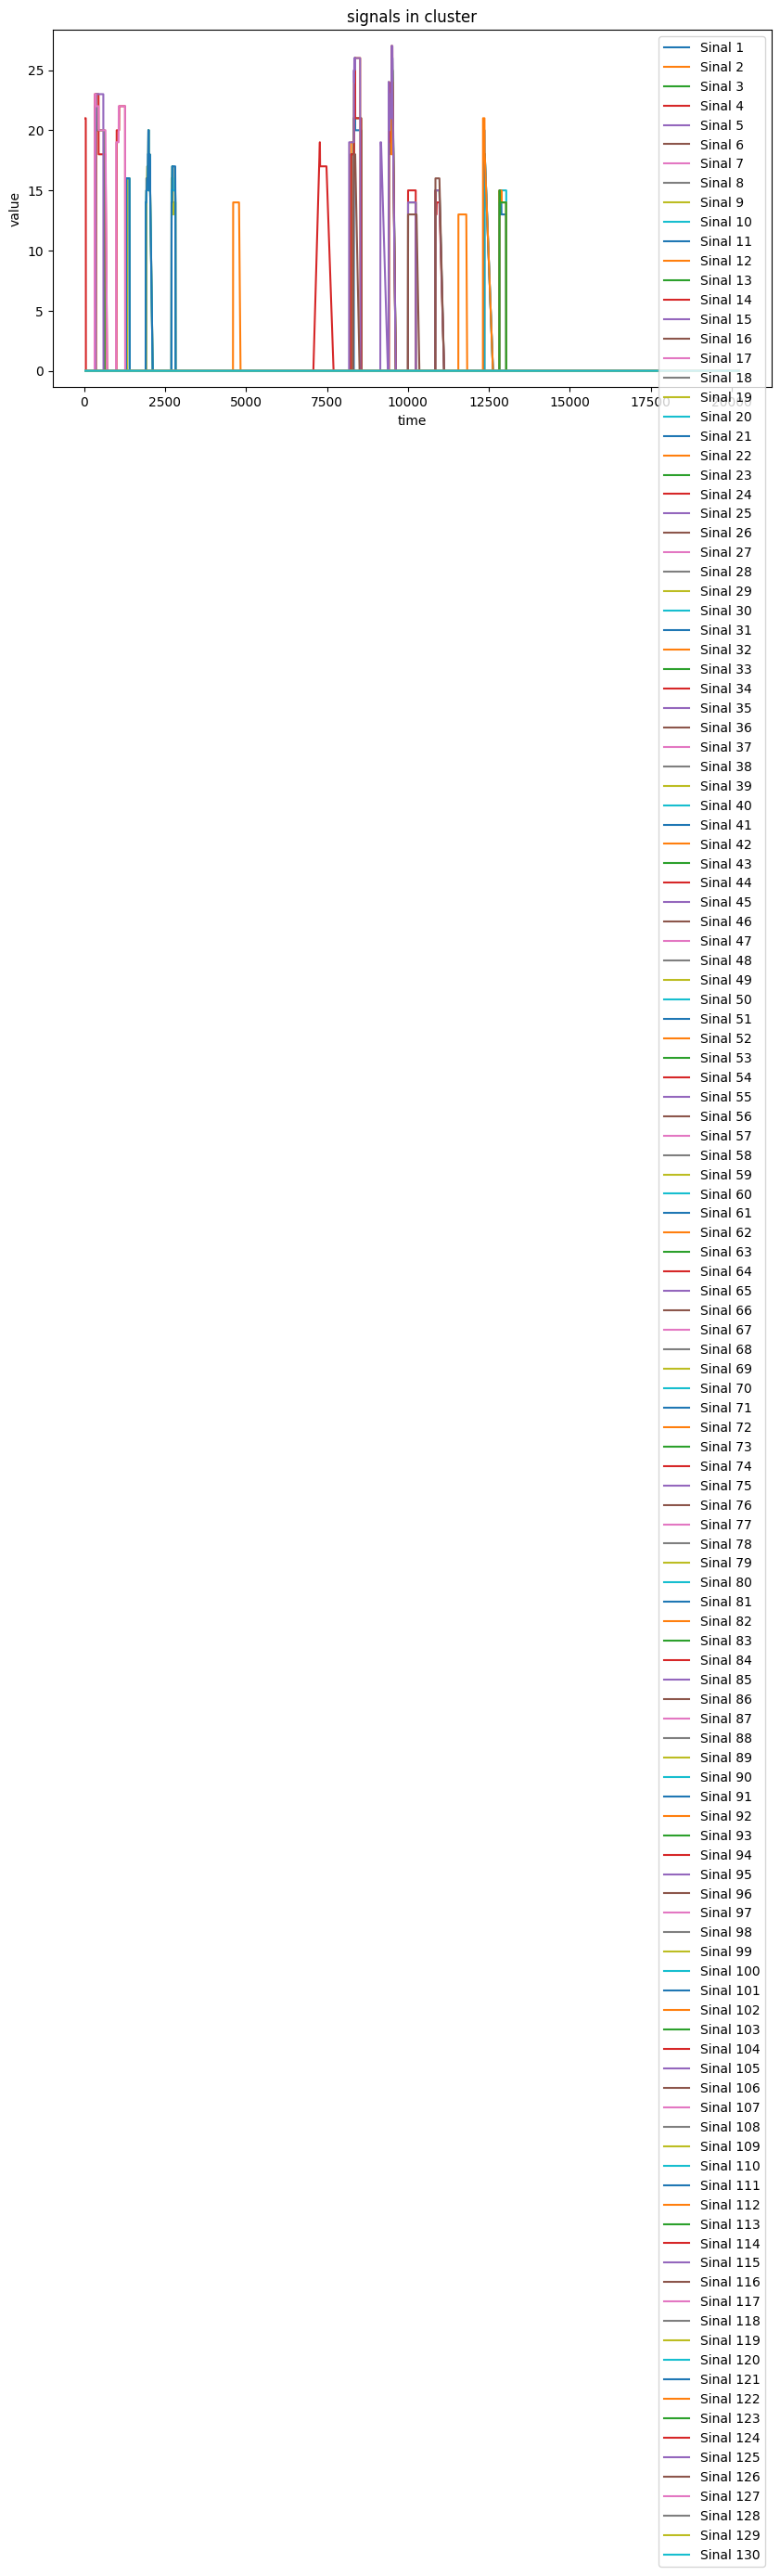

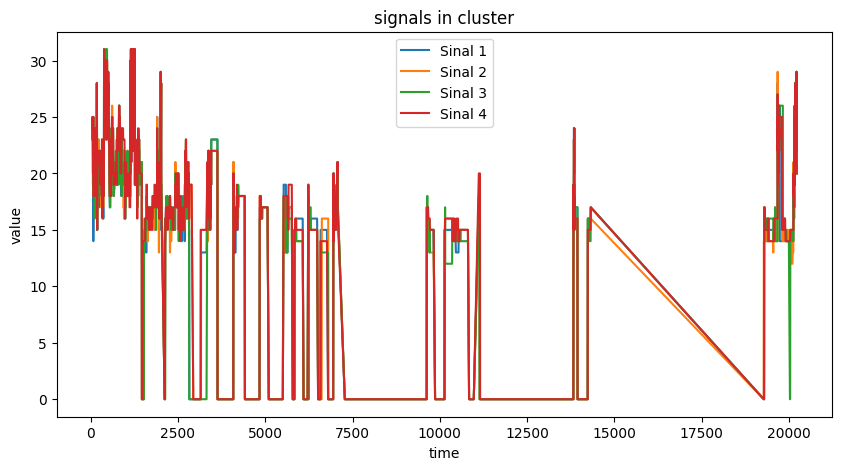

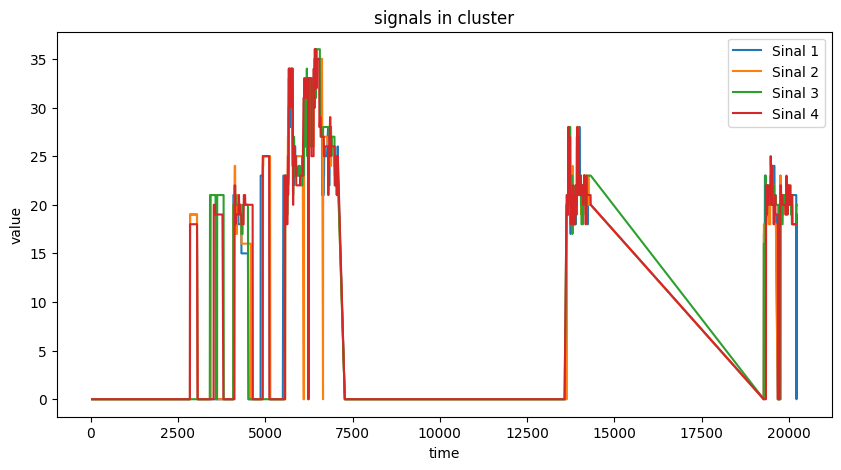

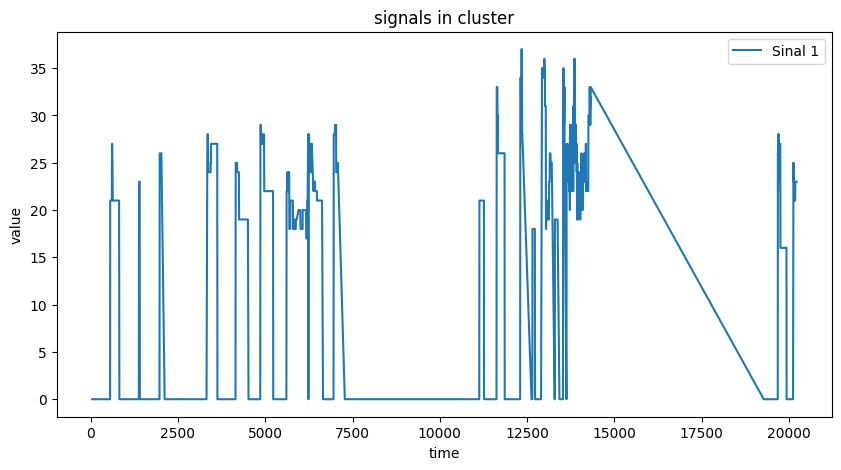

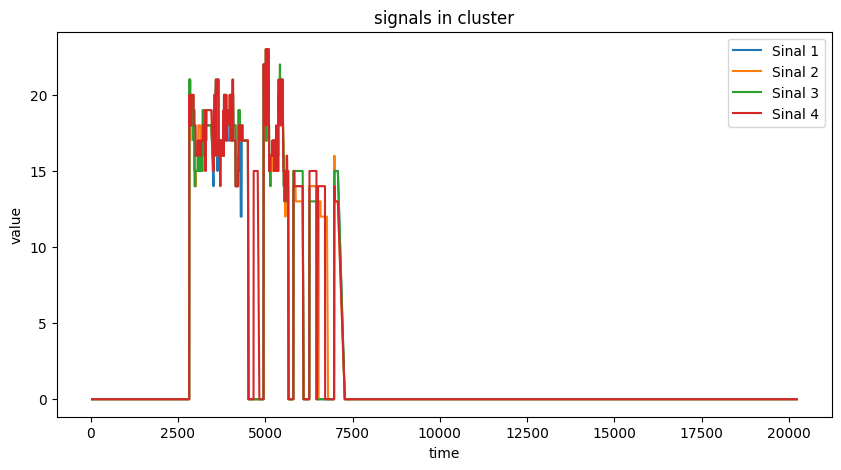

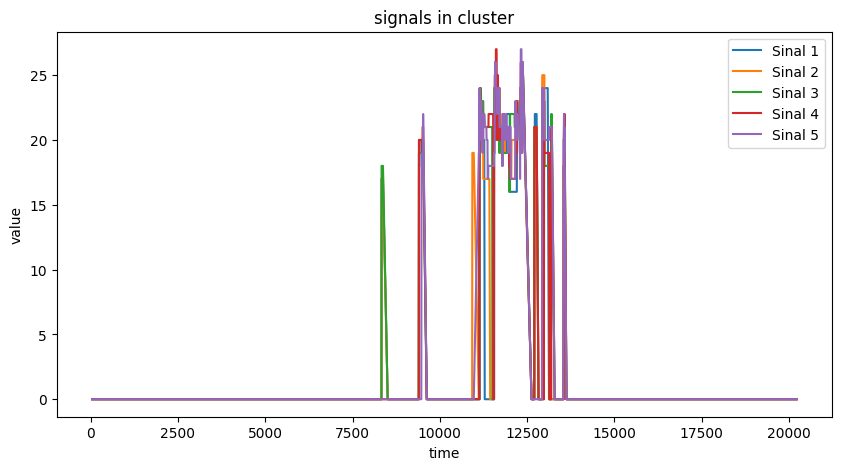

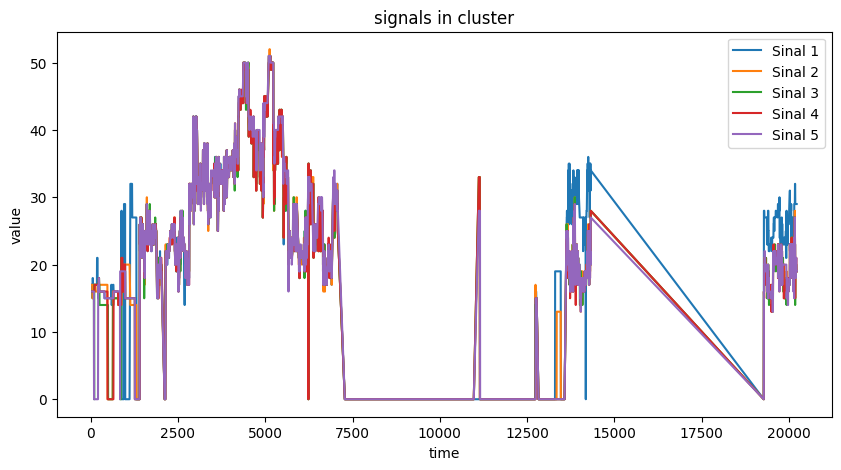

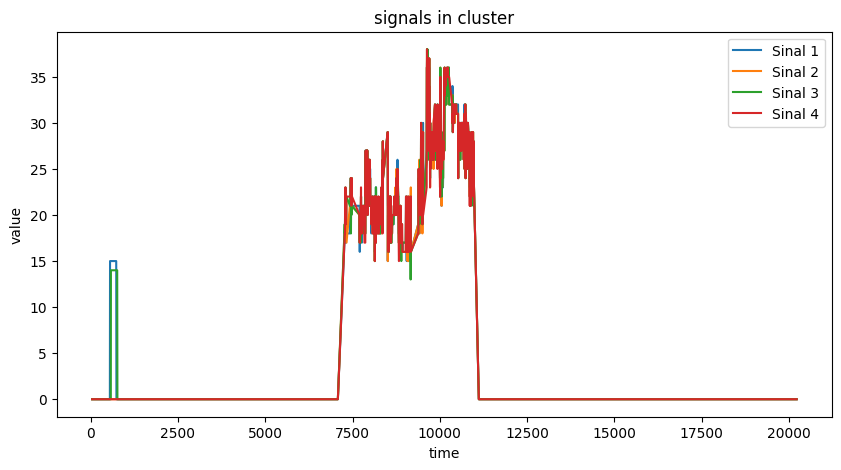

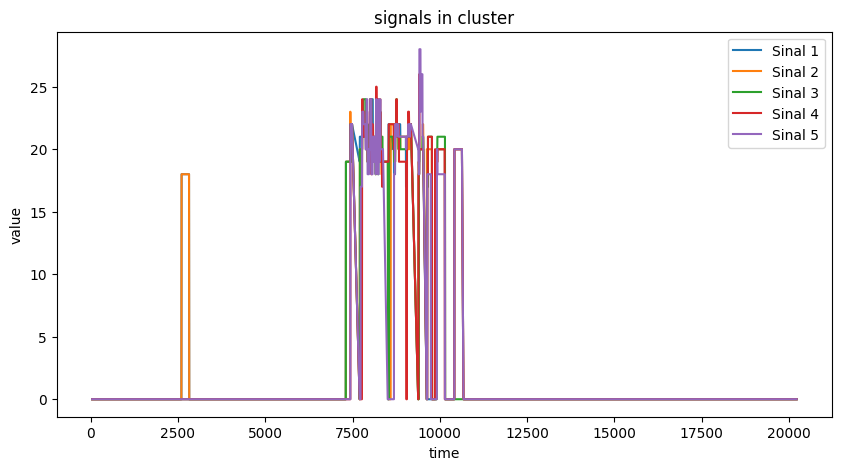

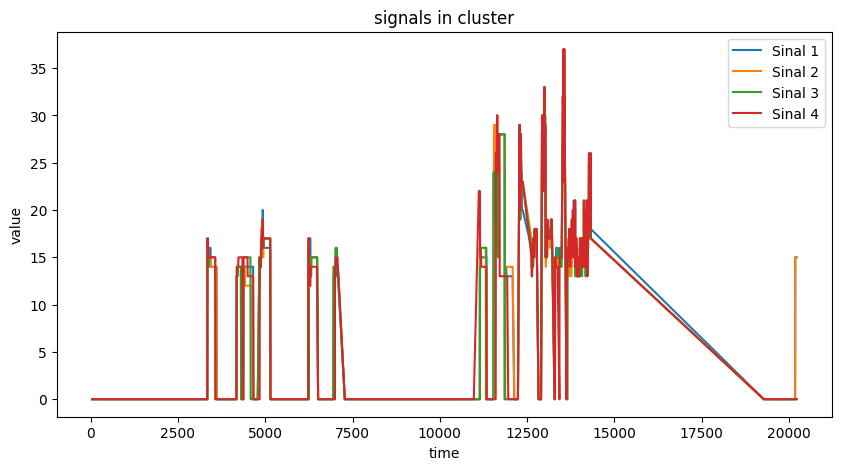

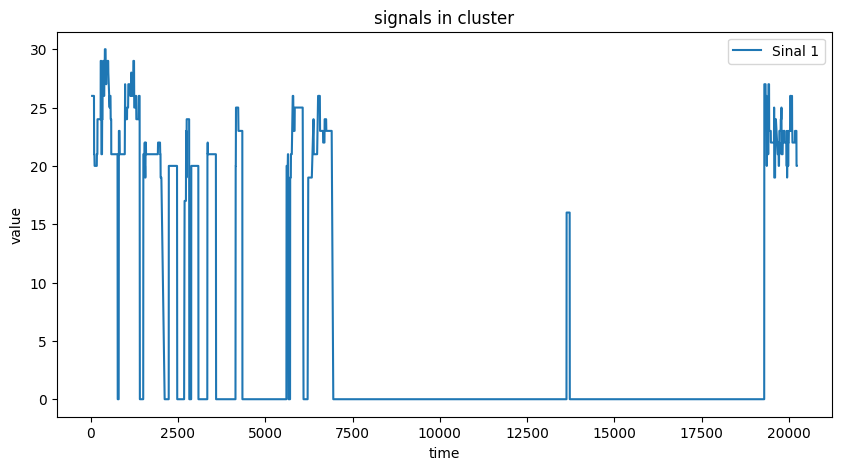

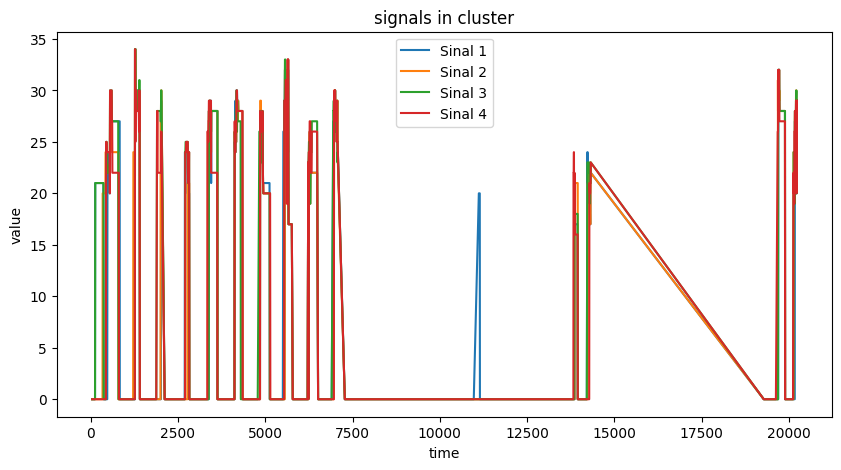

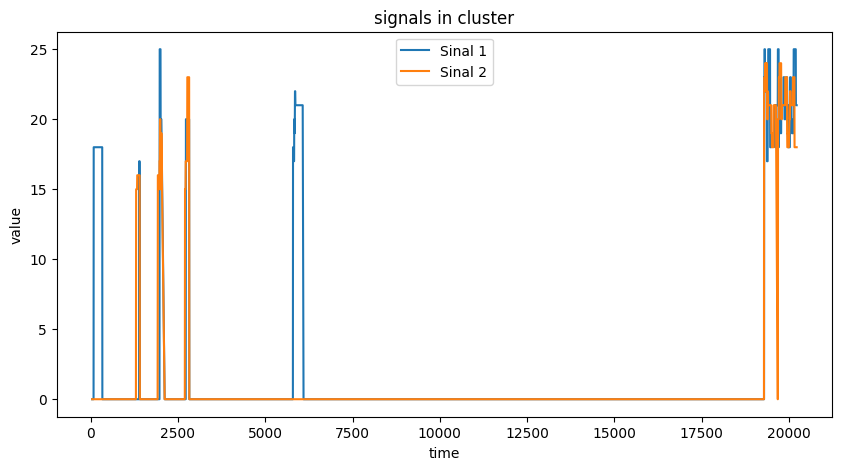

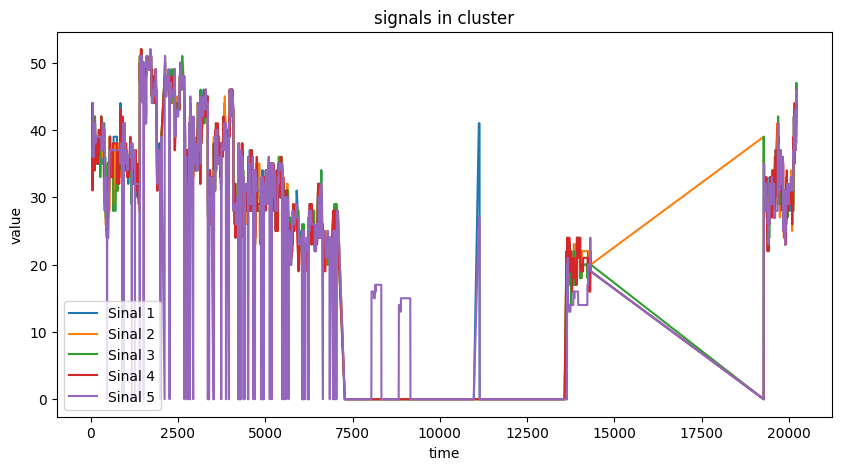

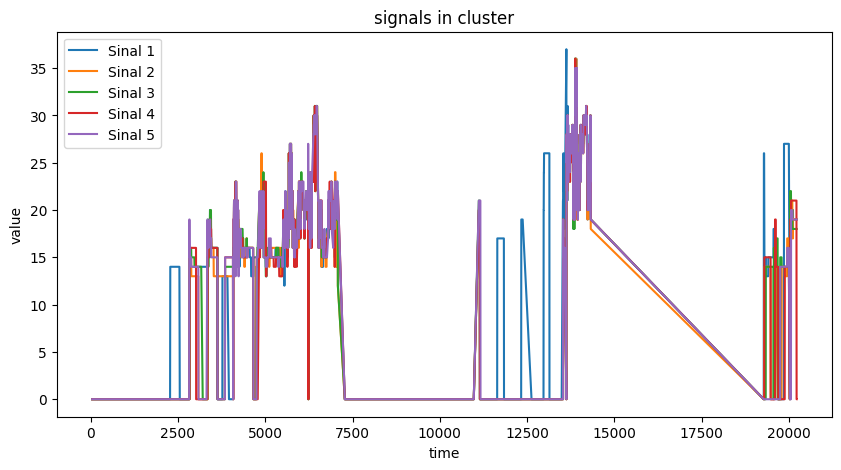

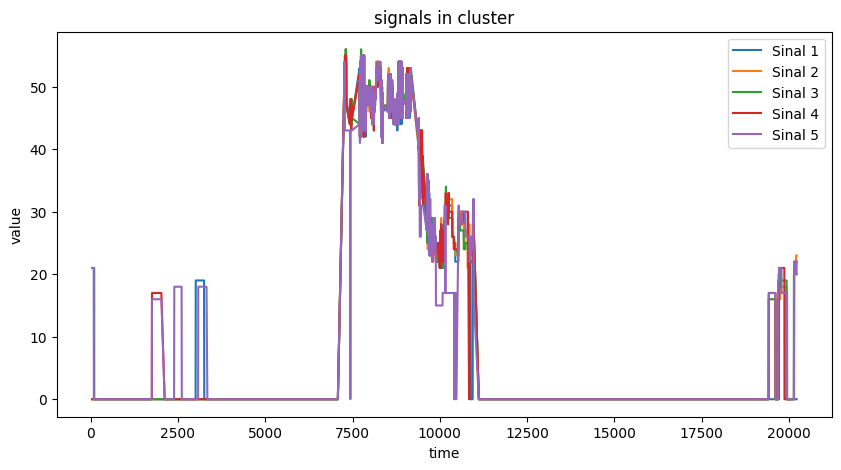

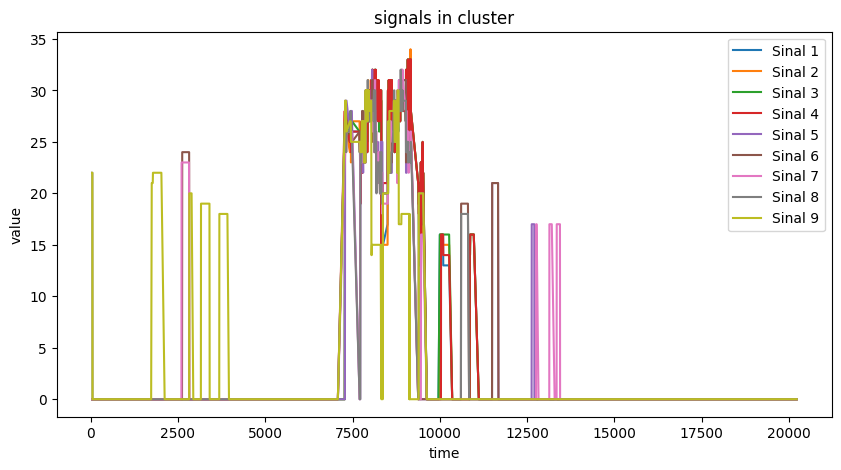

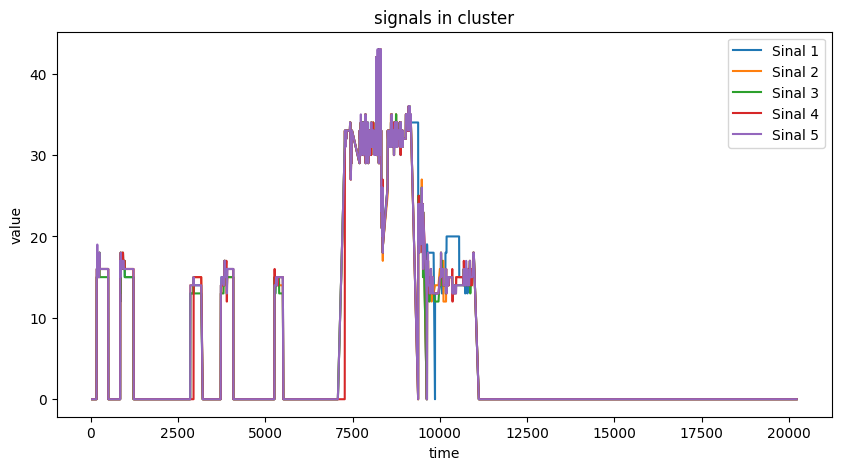

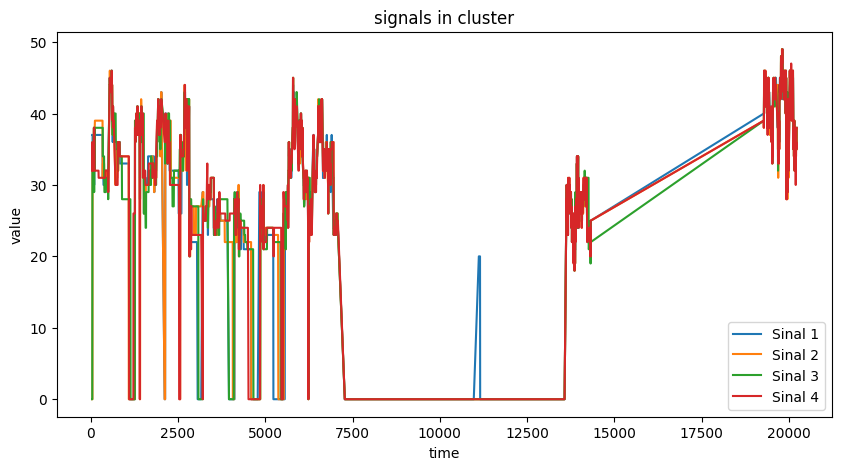

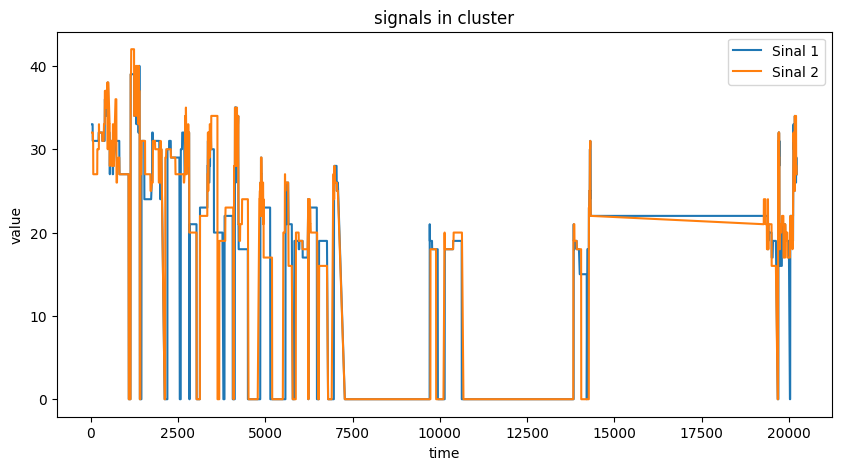

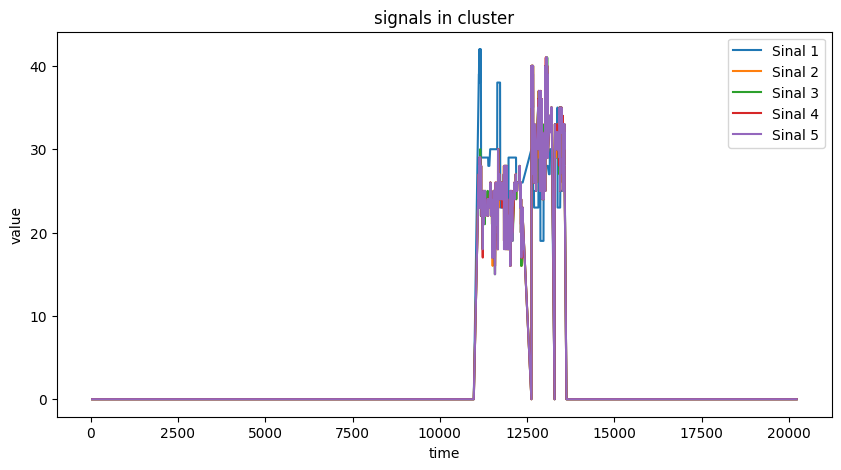

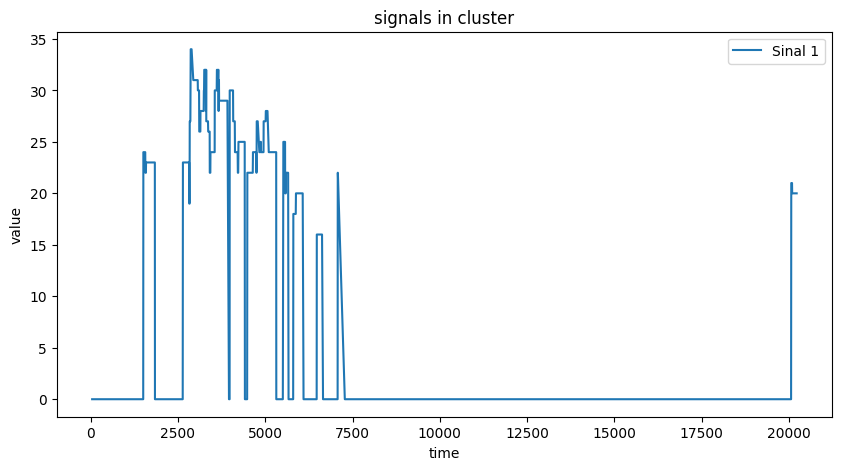

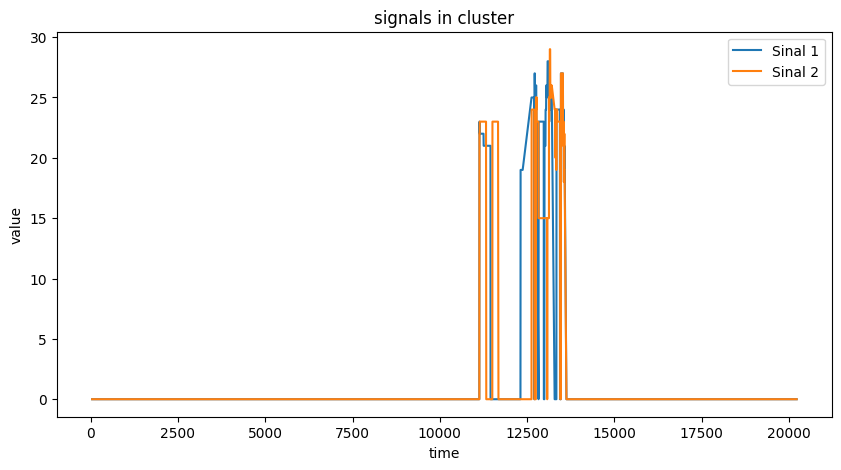

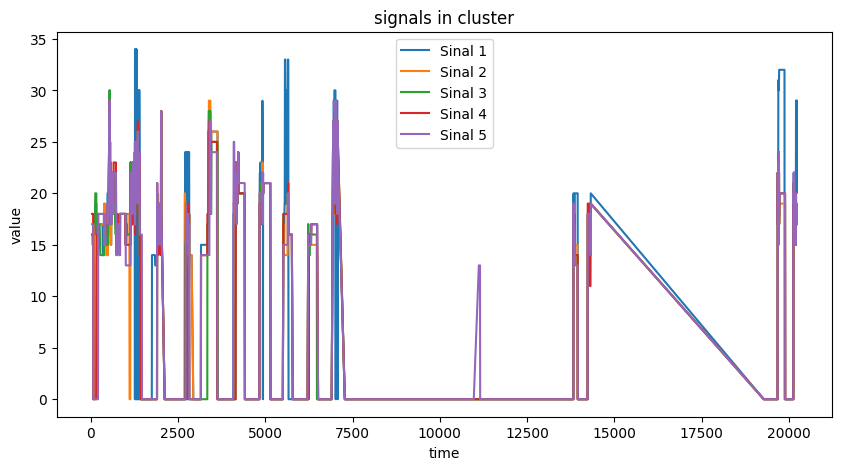

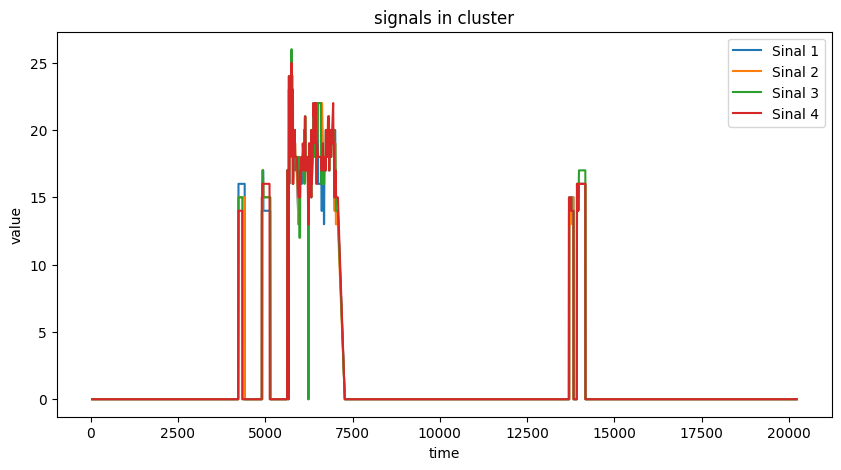

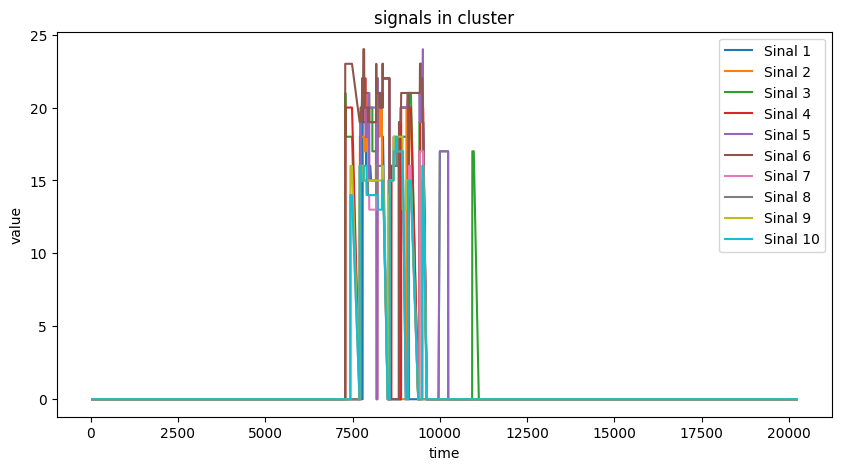

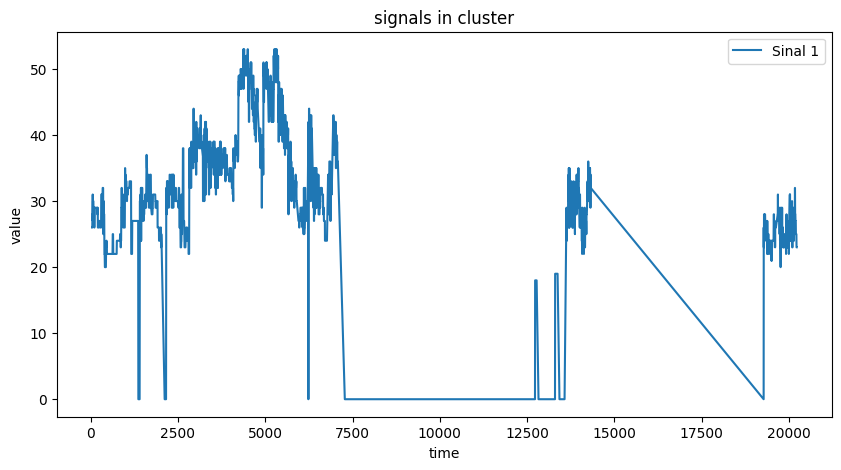

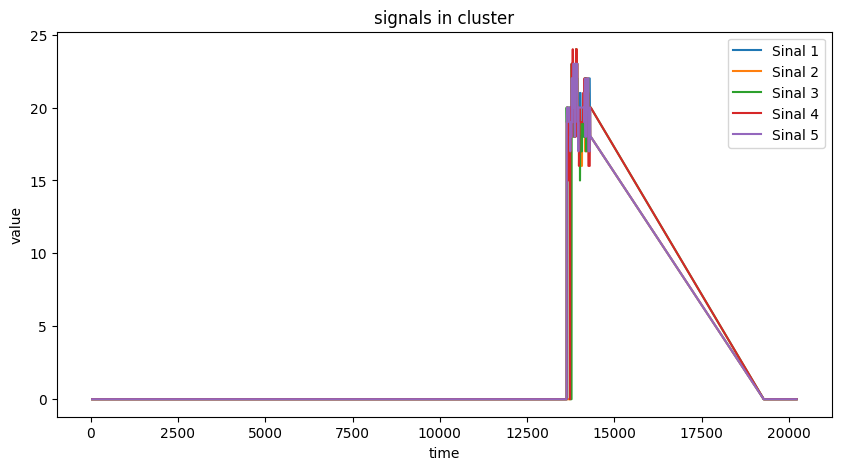

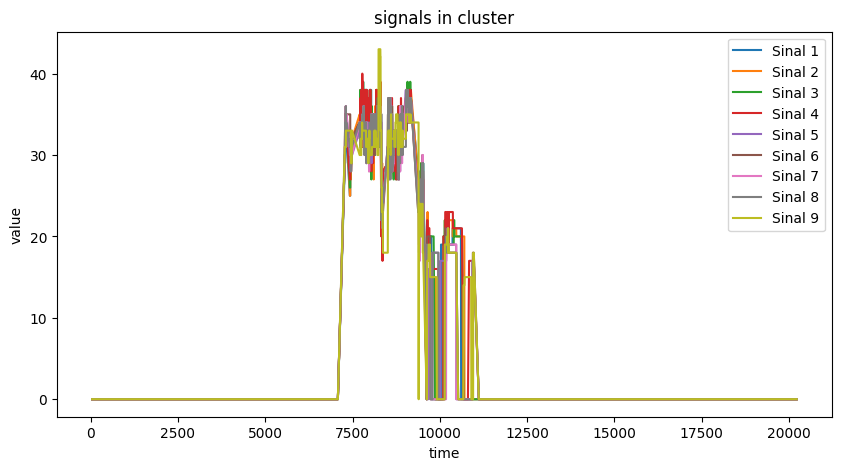

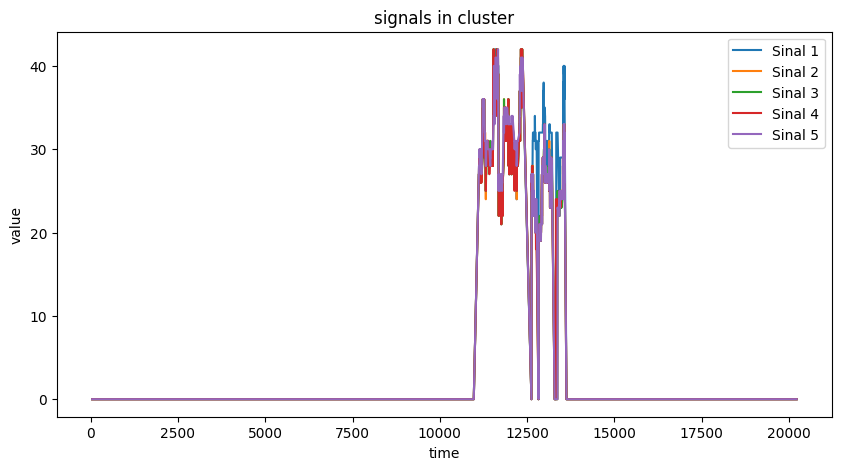

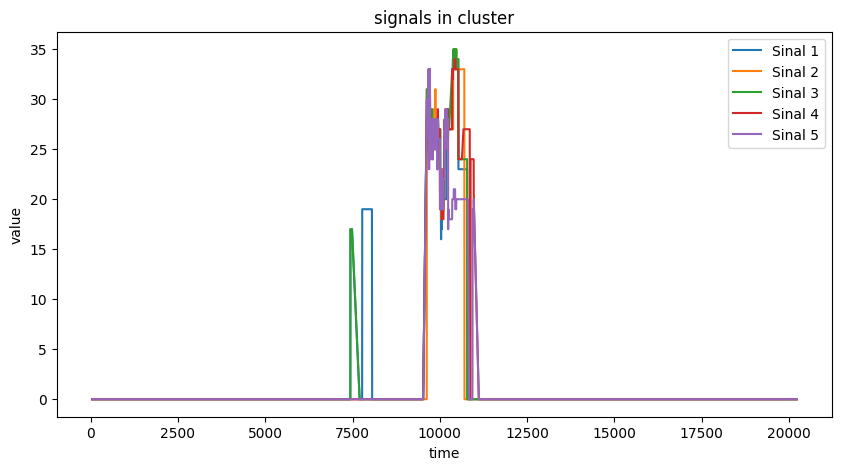

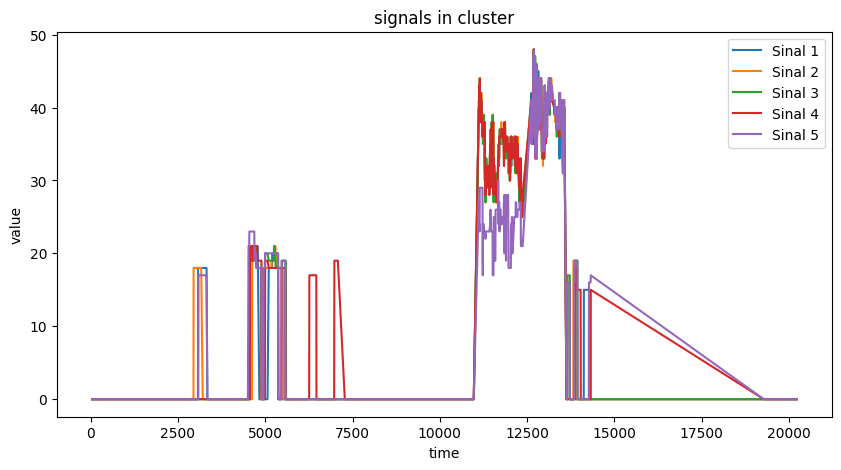

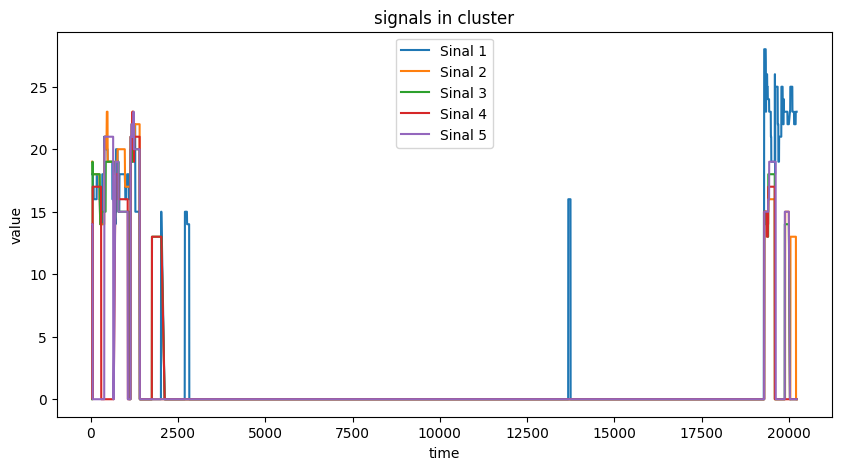

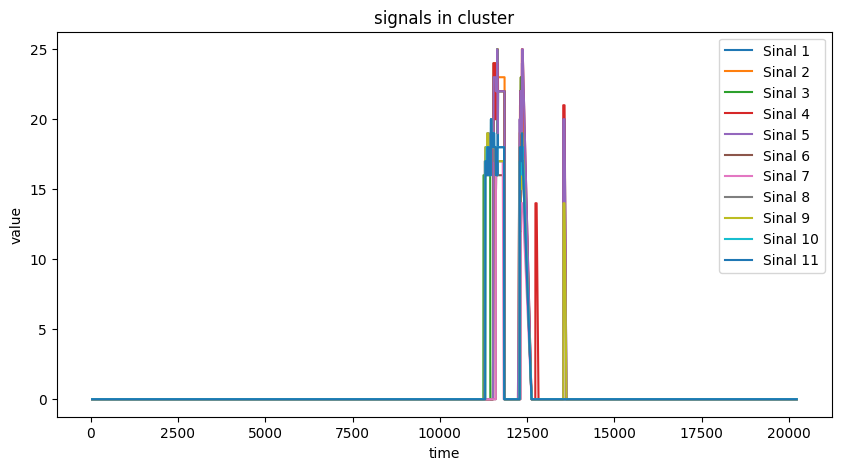

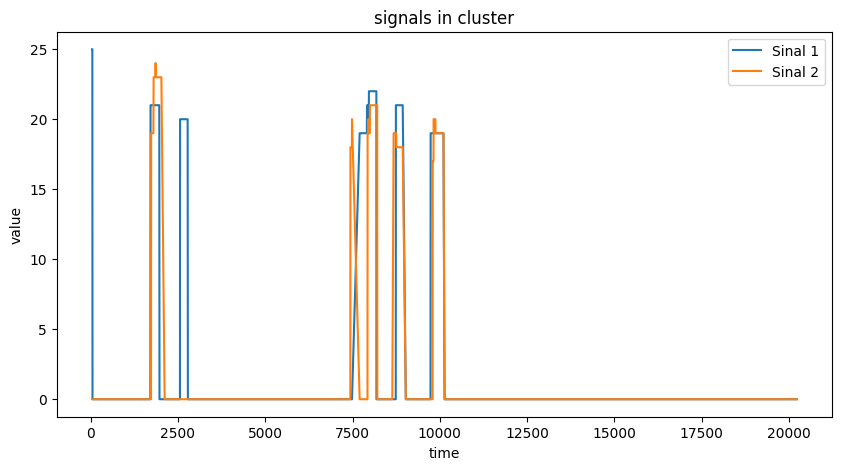

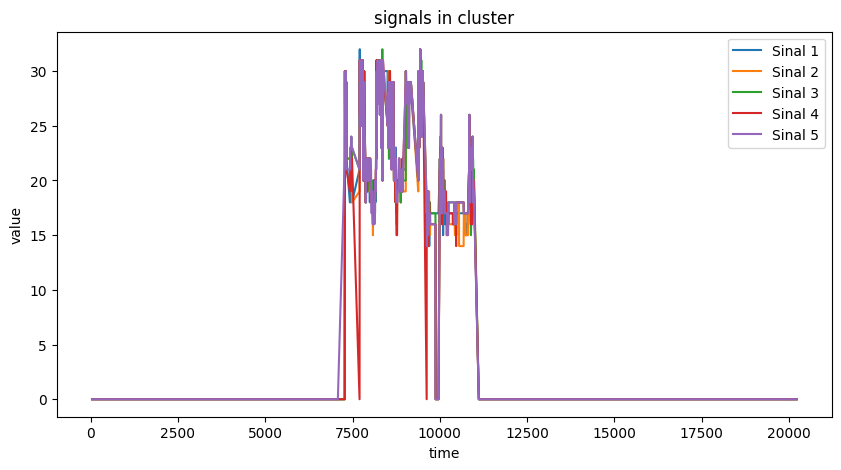

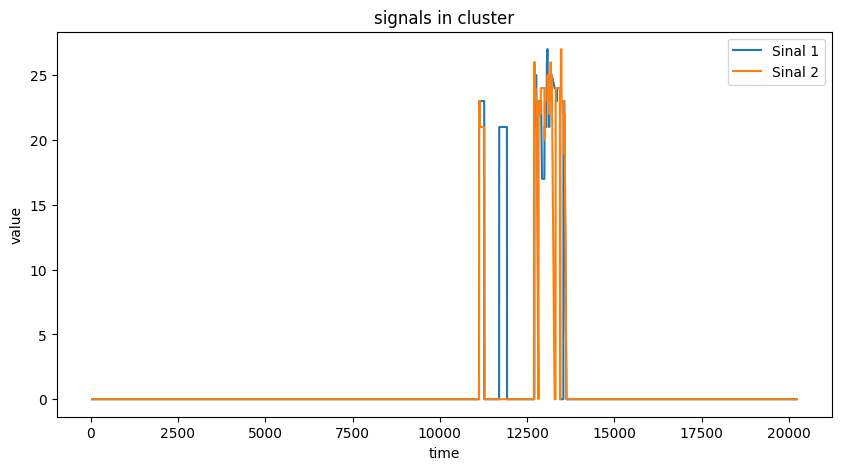

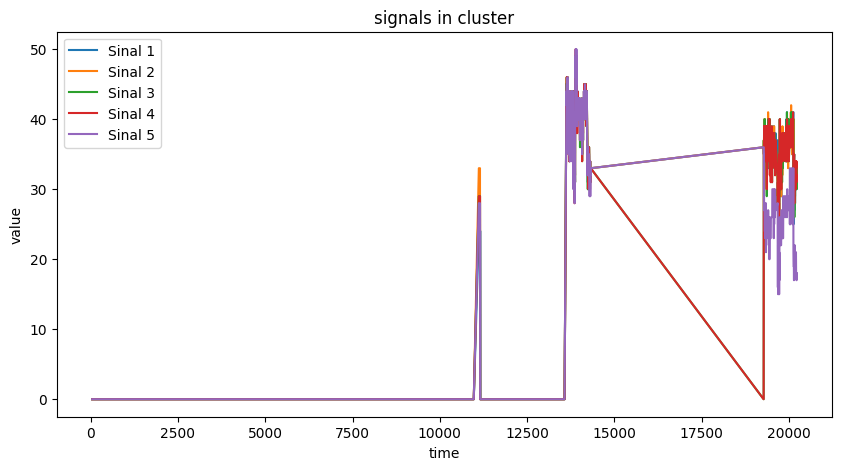

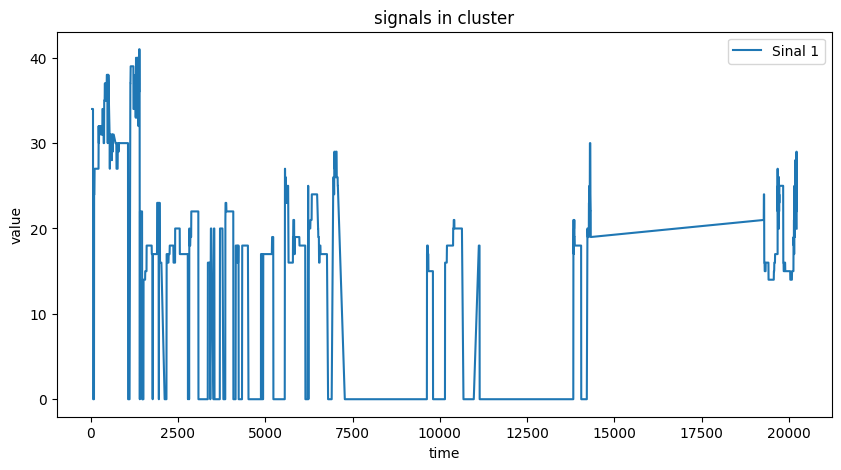

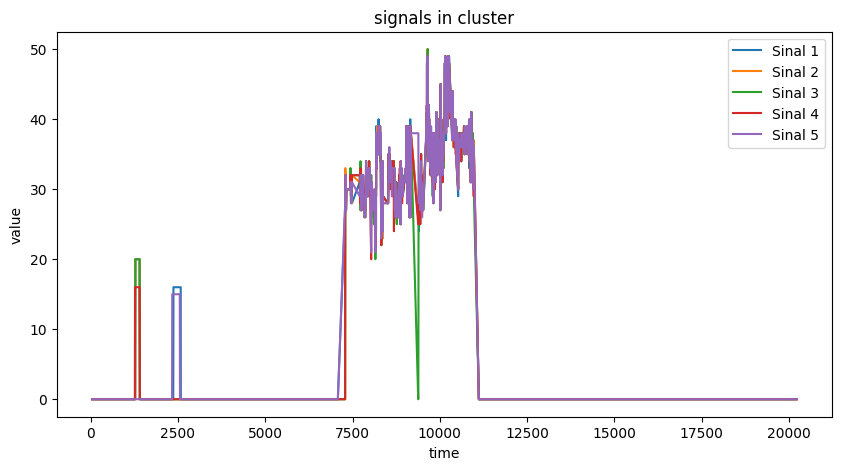

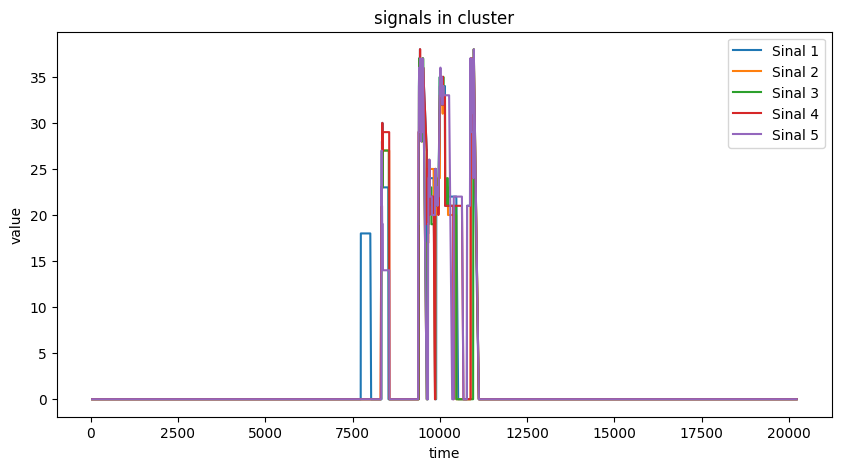

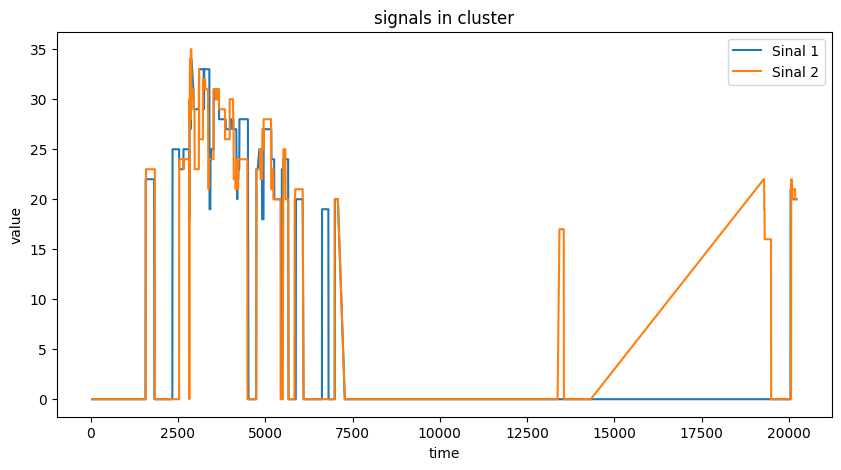

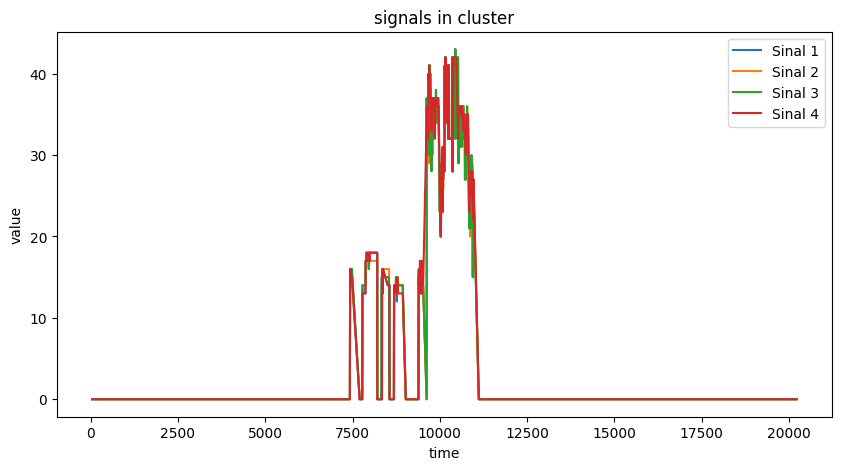

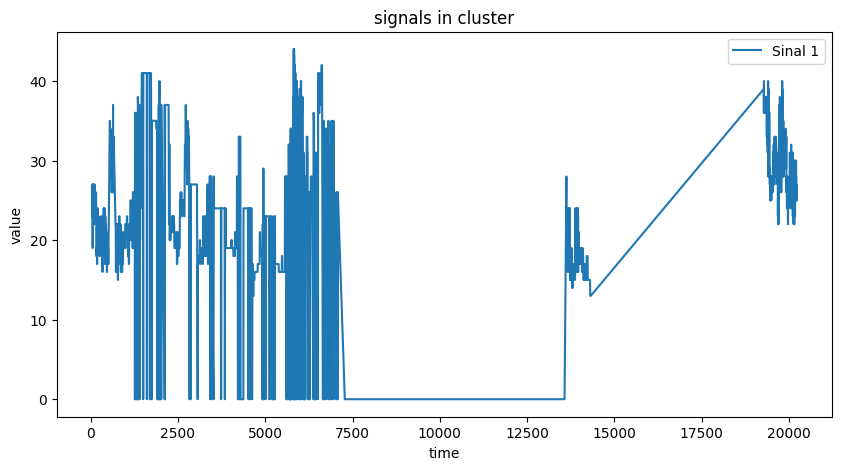

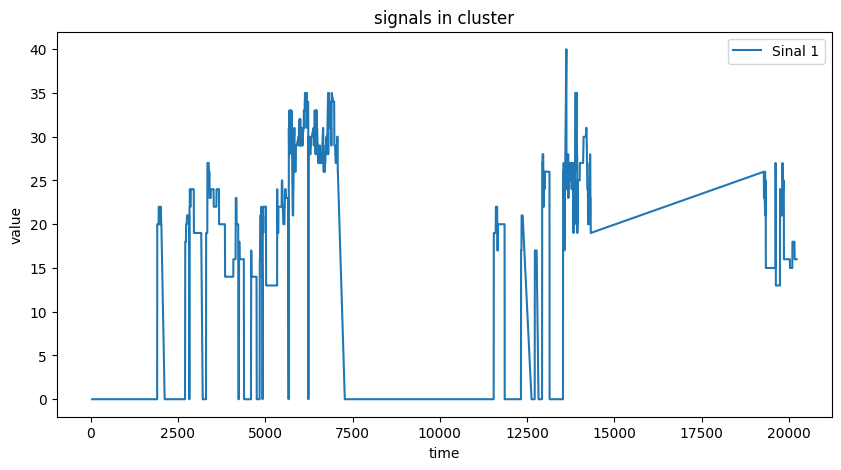

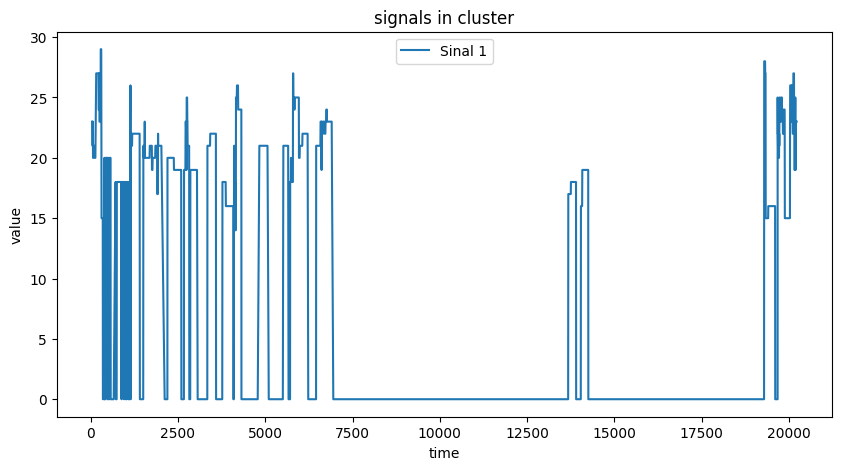

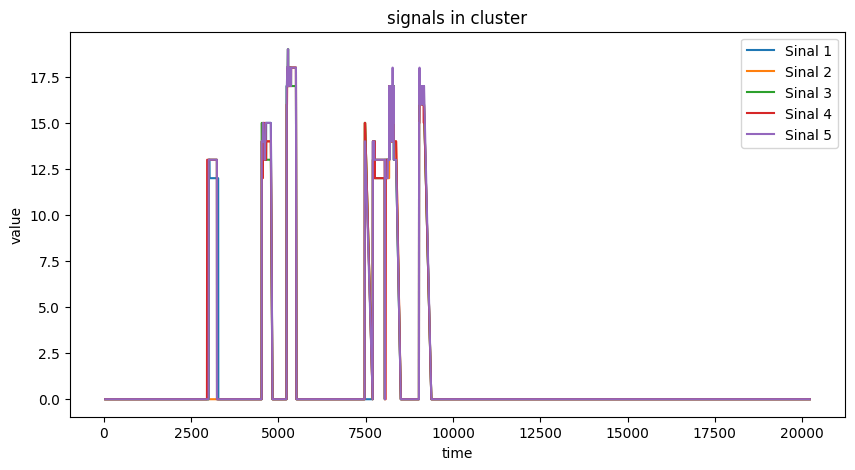

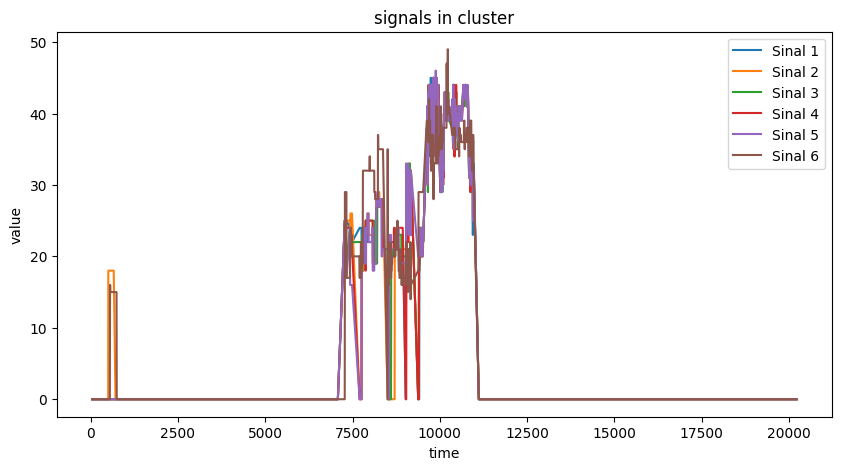

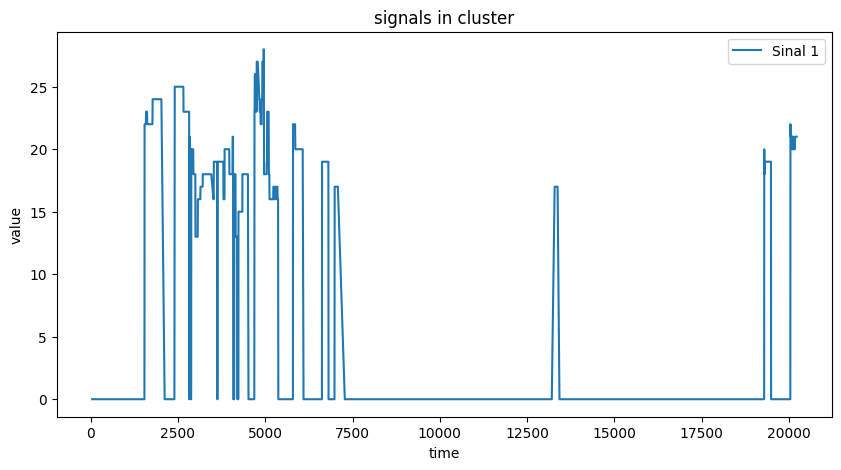

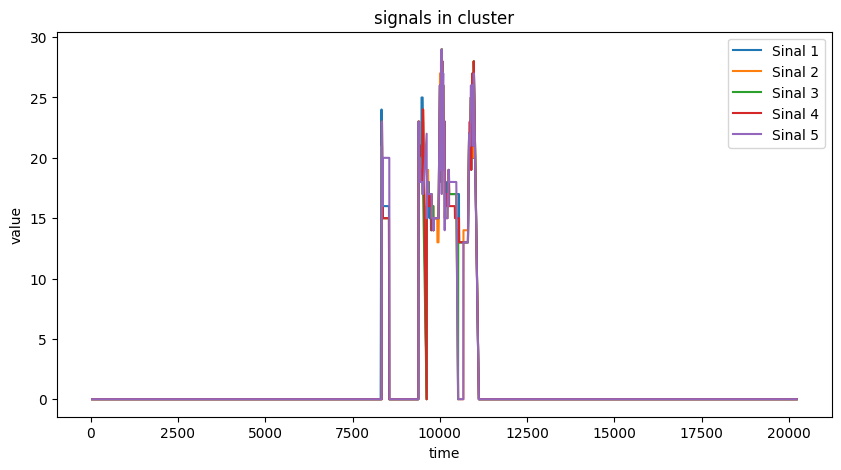

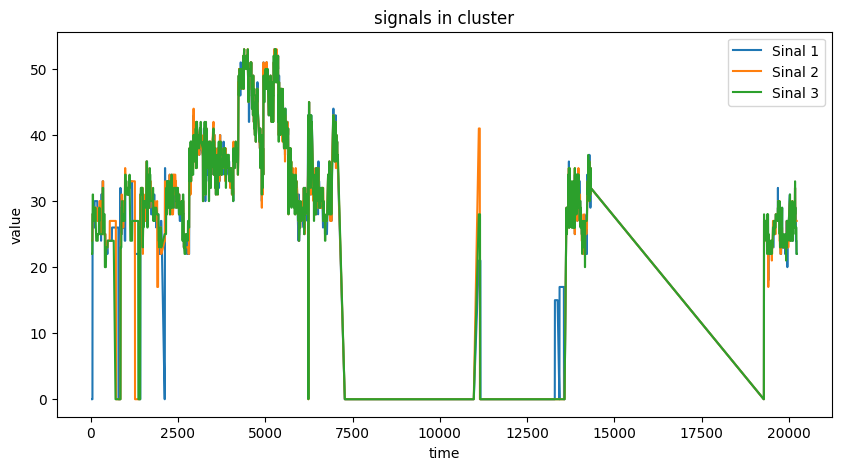

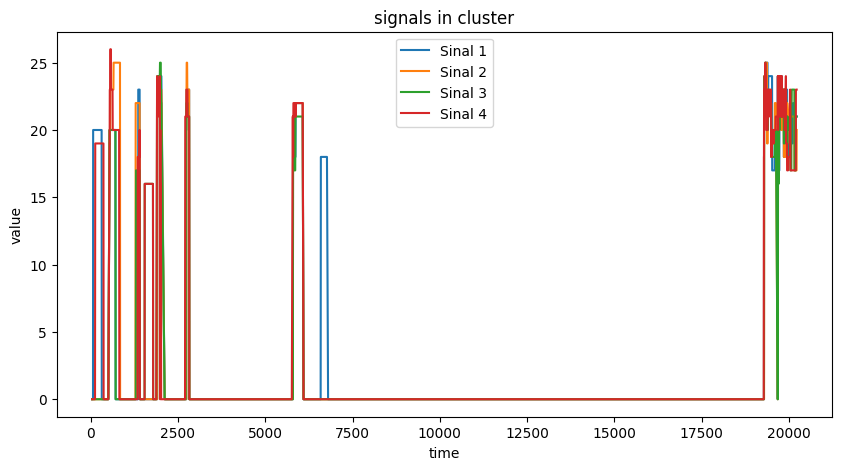

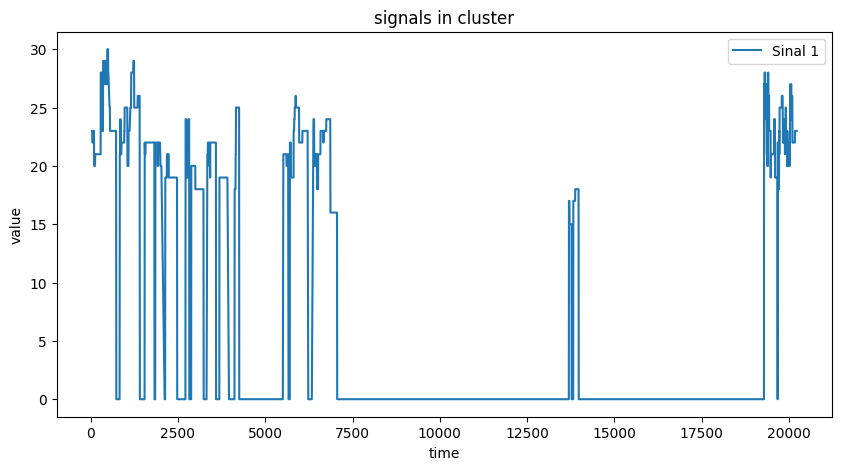

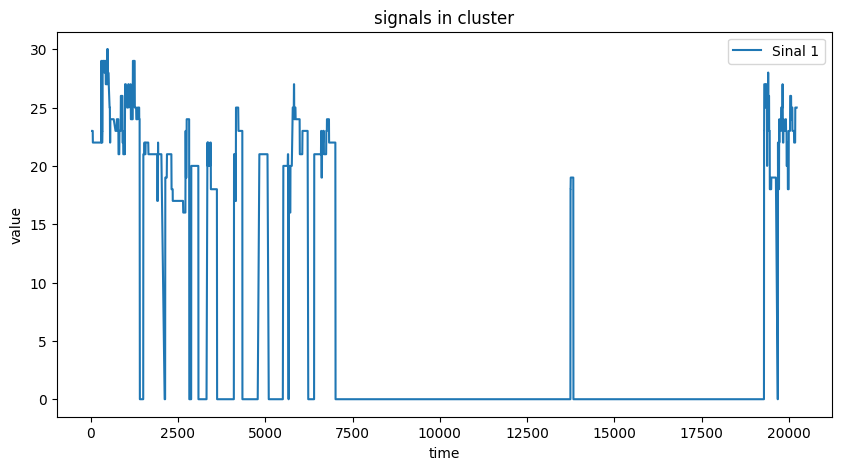

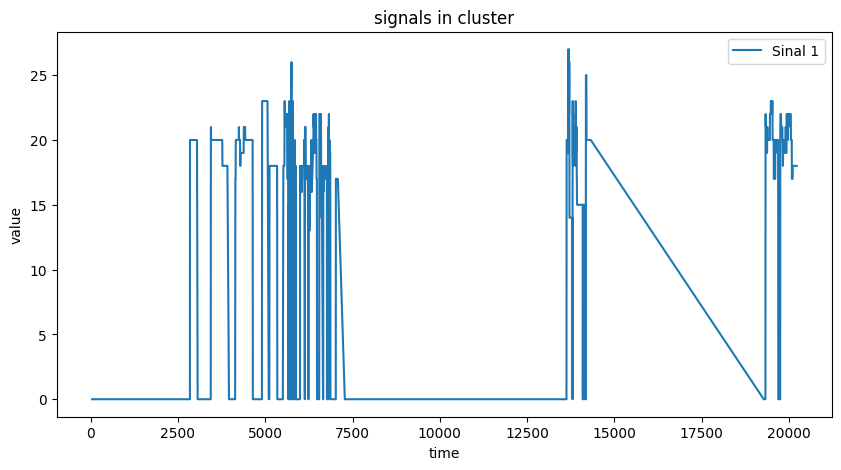

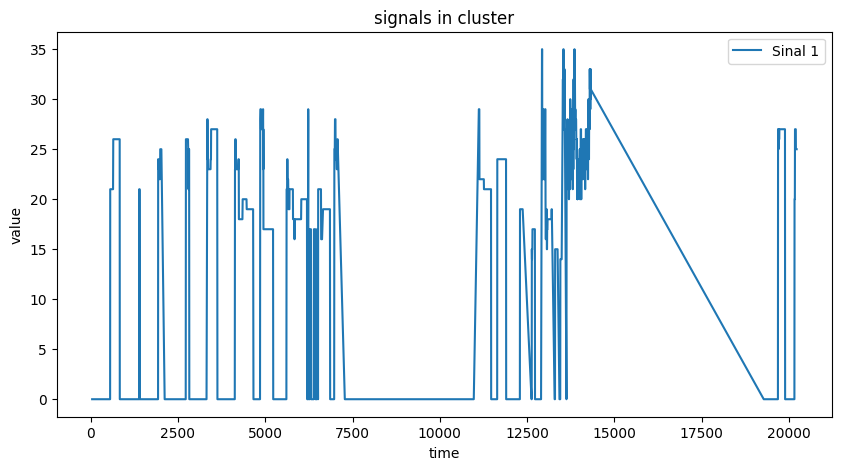

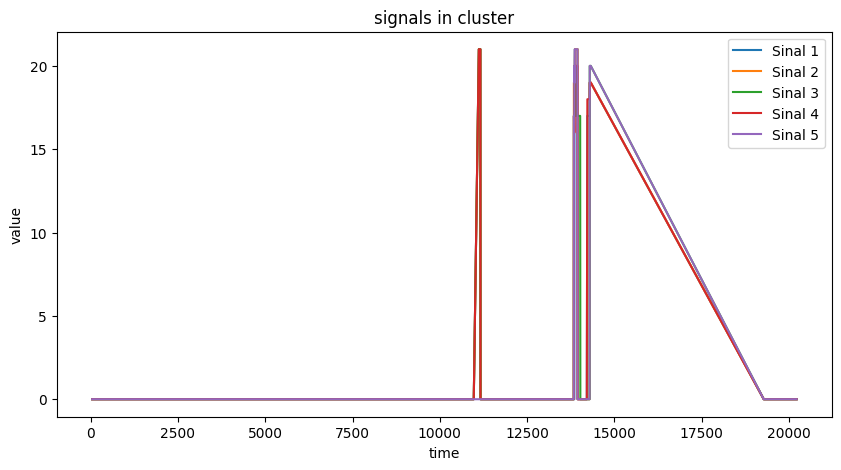

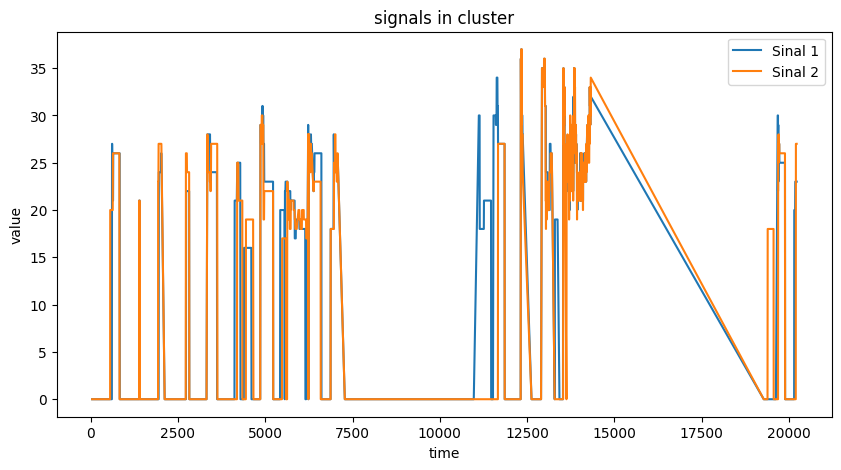

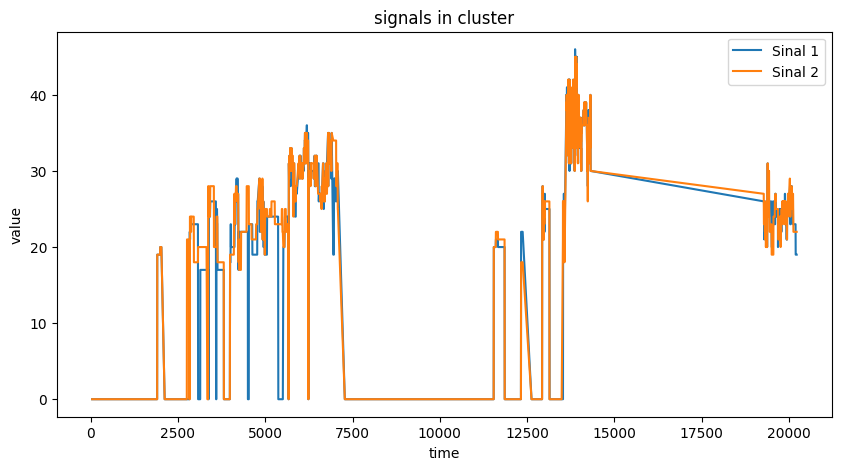

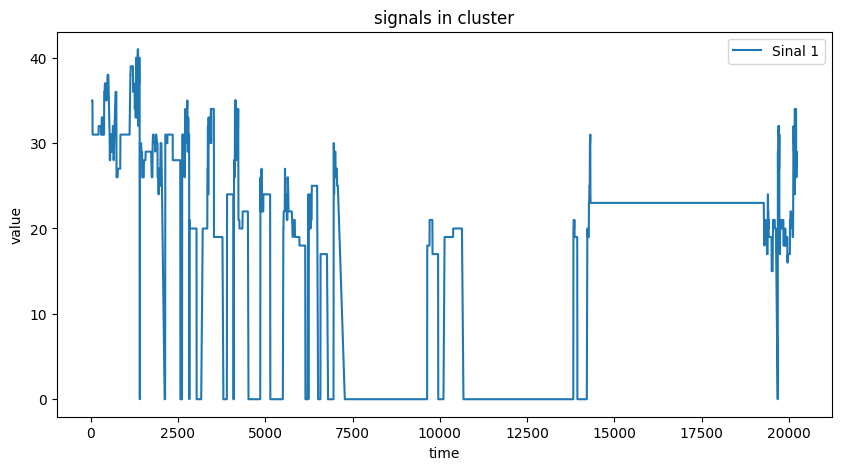

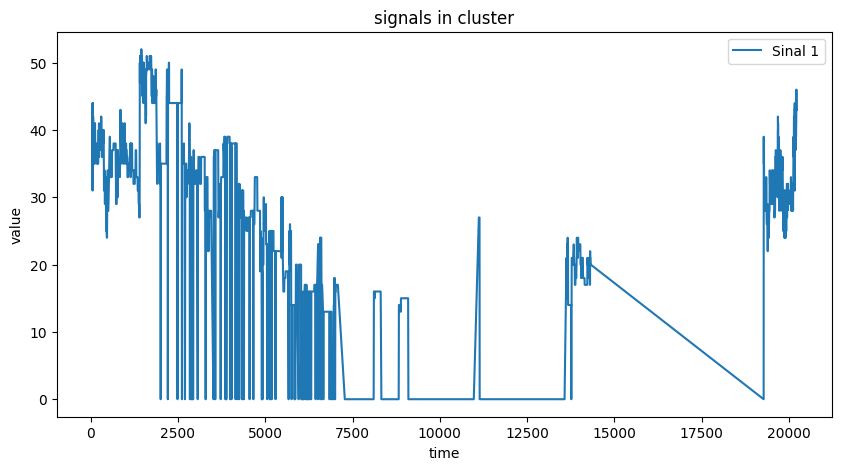

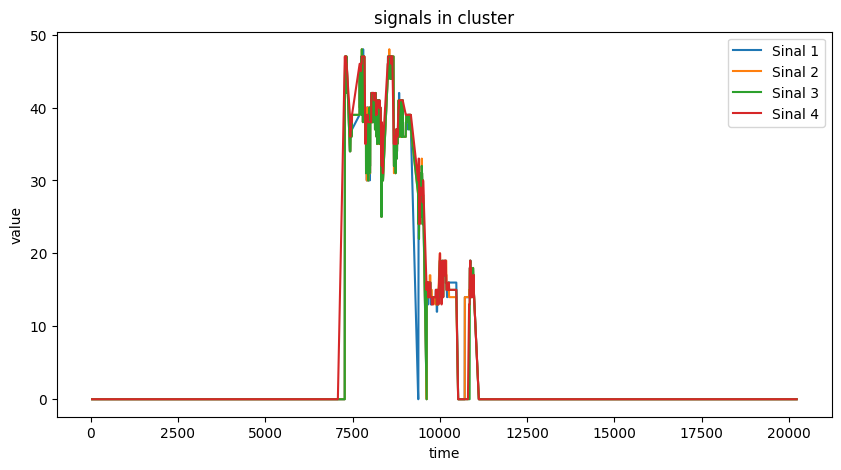

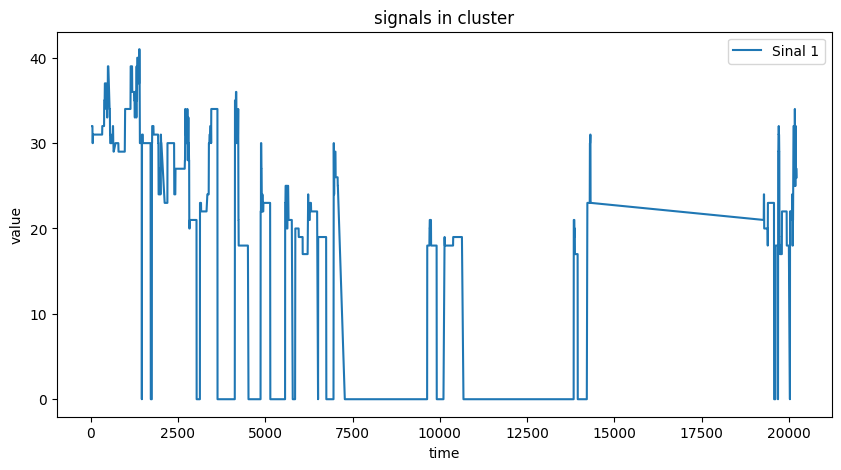

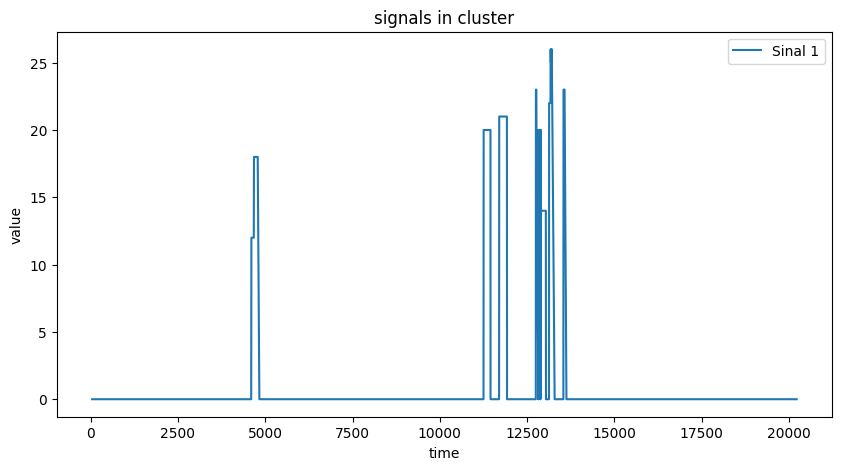

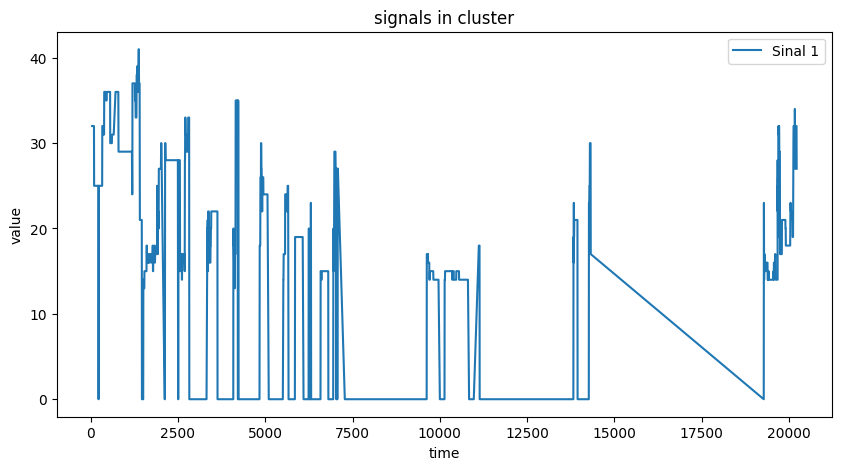

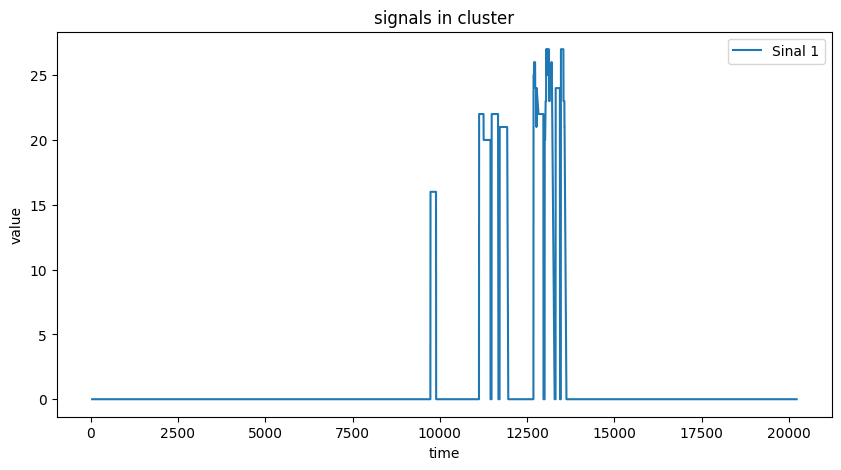

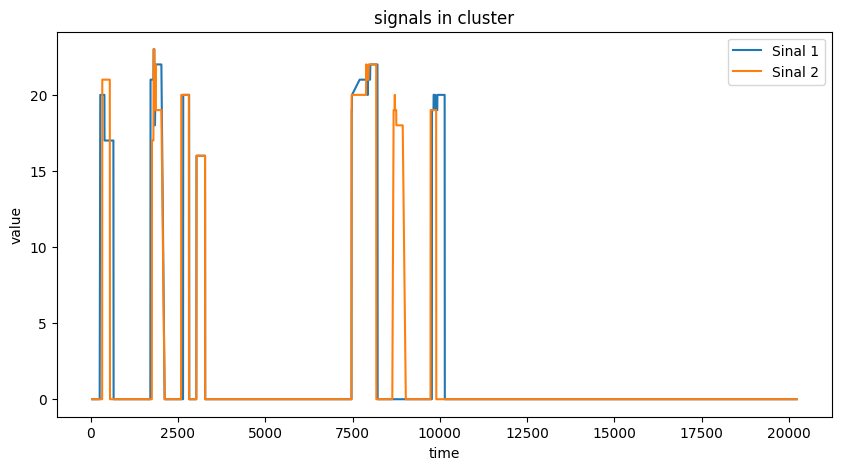

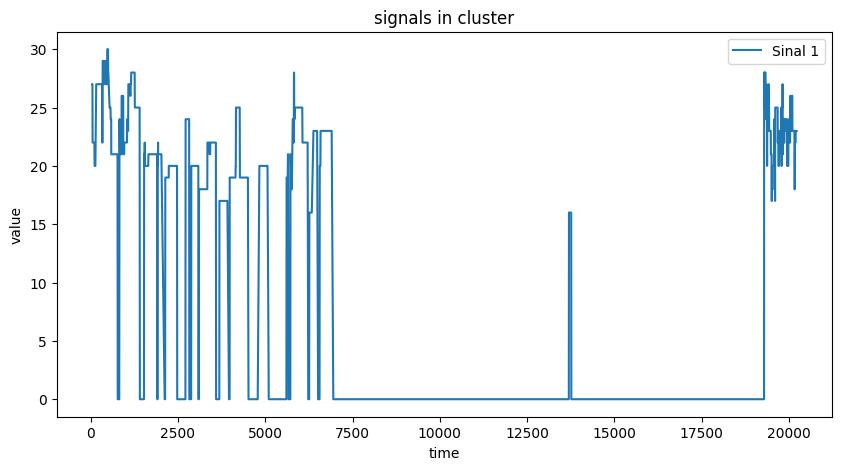

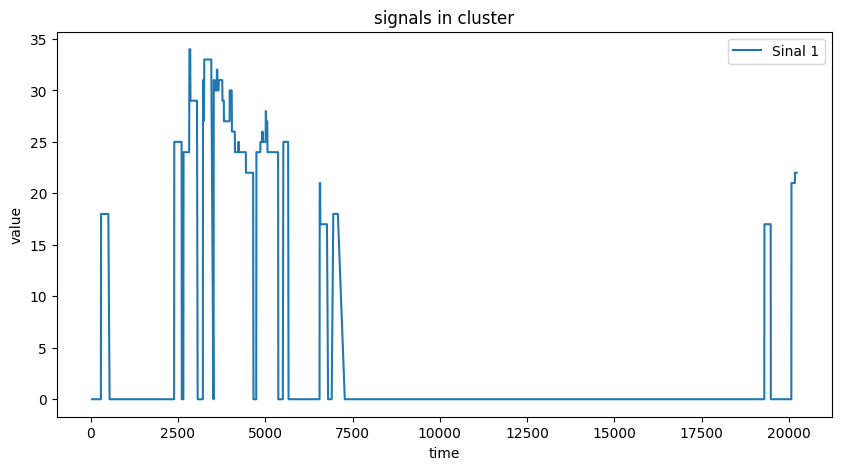

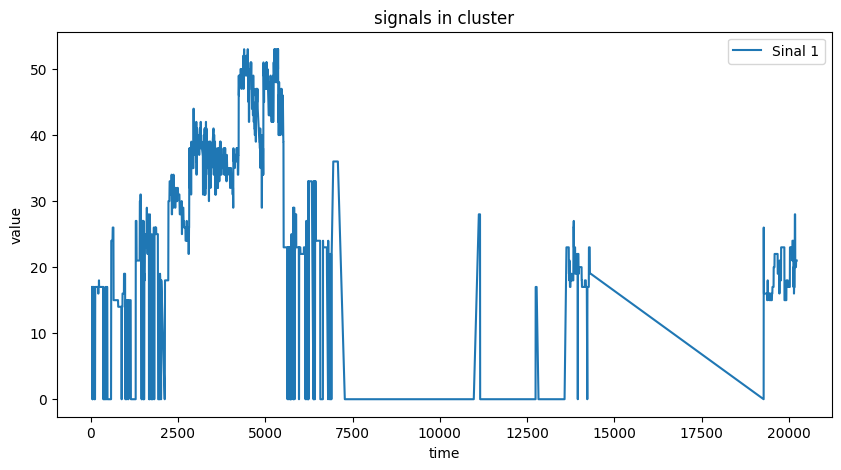

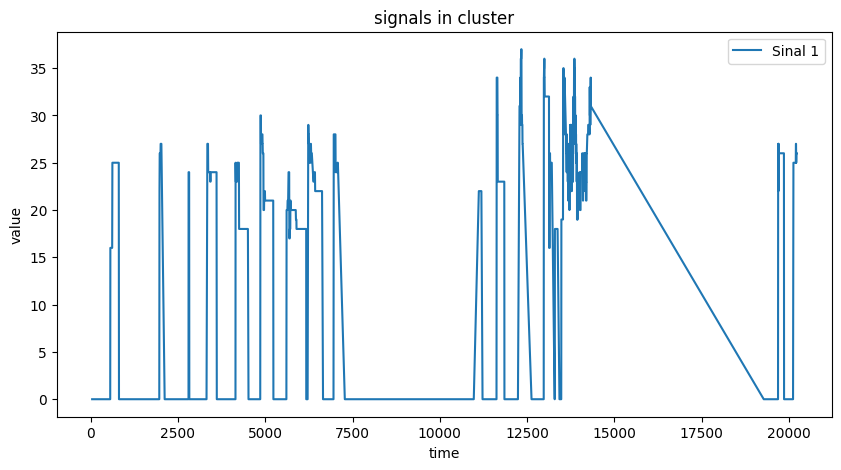

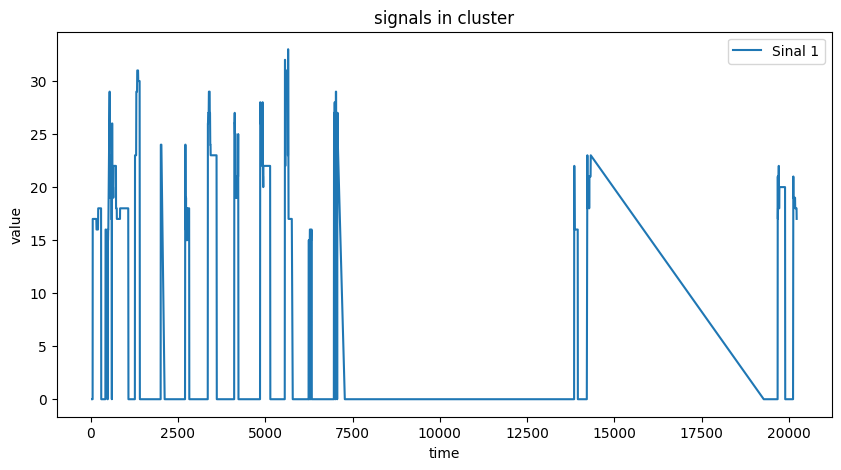

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


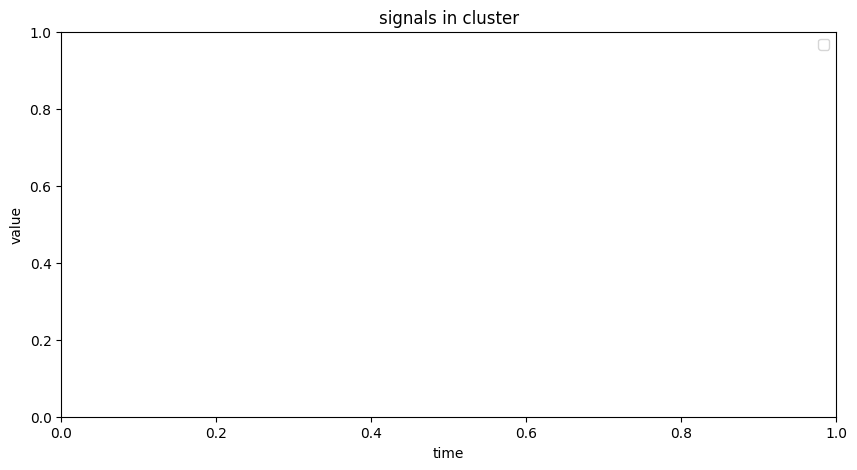

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


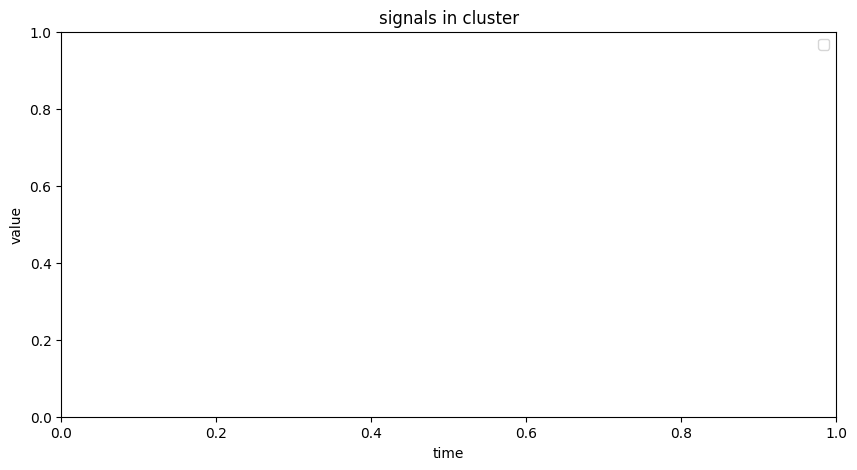

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


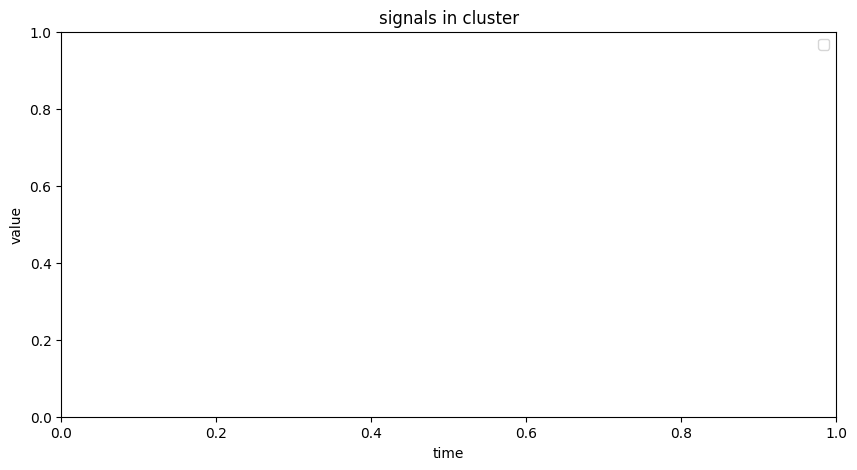

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


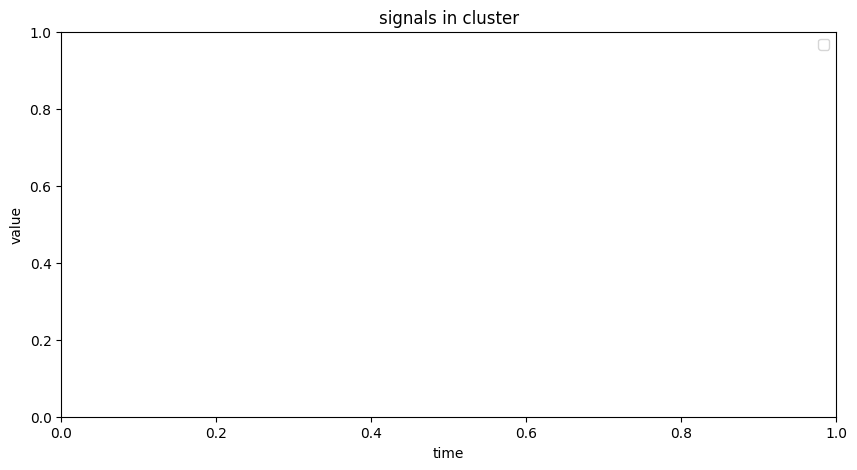

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


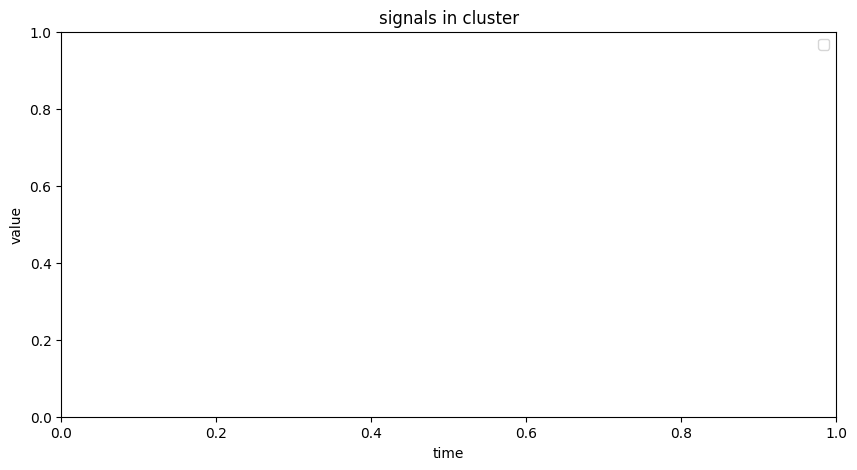

In [11]:
for c in range(85):
    plt.figure(figsize=(10, 5))
    cluster_signals = data_to_cluster[data_to_cluster['cluster'] == c]
    cluster_signals = cluster_signals.drop(columns=["cluster"])
    cluster_signals = cluster_signals.transpose()
    cluster_signals_columns = cluster_signals.columns
    for i in range(len(cluster_signals_columns)):
        plt.plot(cluster_signals[cluster_signals_columns[i]], label=f'Sinal {i+1}')
    plt.title('signals in cluster')
    plt.xlabel('time')
    plt.ylabel('value')
    plt.legend()
    plt.show()
    

Esse approach não está funcionando muito bem, e também temos uma informação muito importante que não estamos utilizando, que é o nome das redes

In [156]:
print(len(name_mac_relation[name_mac_relation["ap_name"] == "Guest-CentraleSupelec"]))
print(len(name_mac_relation[name_mac_relation["ap_name"] == "fabrique2024"]))
print(len(name_mac_relation[name_mac_relation["ap_name"] == "stop&go"]))
print(len(name_mac_relation[name_mac_relation["ap_name"] == "CD91"]))
print(len(name_mac_relation[name_mac_relation["ap_name"] == "eduroam"]))



86
86
62
87
88


In [157]:
eduroam_aps = list(name_mac_relation[name_mac_relation["ap_name"] == "eduroam"]["ap_mac"])
gues_aps = list(name_mac_relation[name_mac_relation["ap_name"] == "Guest-CentraleSupelec"]["ap_mac"])
stop_aps = list(name_mac_relation[name_mac_relation["ap_name"] == "stop&go"]["ap_mac"])
cd_aps = list(name_mac_relation[name_mac_relation["ap_name"] == "CD91"]["ap_mac"])
fabirque_aps = list(name_mac_relation[name_mac_relation["ap_name"] == "fabrique2024"]["ap_mac"])

In [160]:
data_to_cluster = data[data["device_id"] == "C"][AP_columns]

In [171]:
for ap in eduroam_aps[2:]:
    best = None
    best_distance = None

    for ap_stop in stop_aps:  # Itera sobre todas as colunas exceto a primeira (timestamp) e sinal1
        distance = np.linalg.norm(data_to_cluster[ap] - data_to_cluster[ap_stop])
        if best == None:
            best = ap_stop
            best_distance = distance
        elif distance < best_distance:
            print("a")
            best = ap_stop
            best_distance = distance
    break

a
a
a


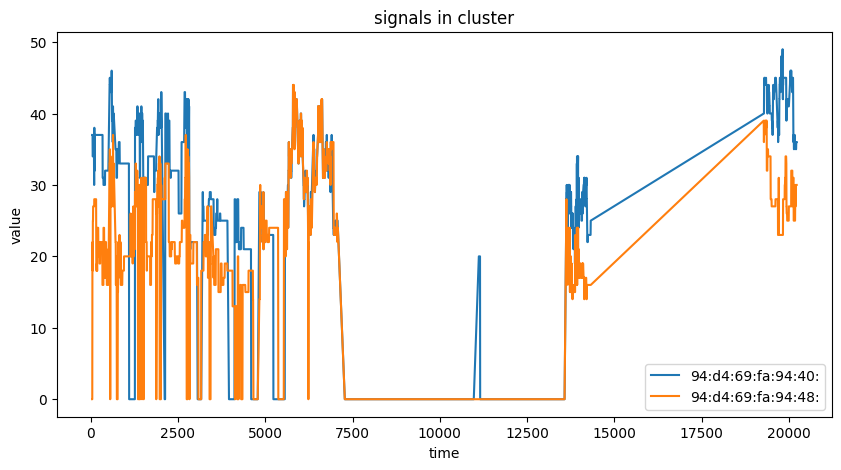

In [172]:
plt.figure(figsize=(10, 5))
plt.plot(data_to_cluster[eduroam_aps[2]], label=eduroam_aps[2])
plt.plot(data_to_cluster[best], label=best)

plt.title('signals in cluster')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

In [174]:
name_mac_relation[name_mac_relation['ap_mac'].str.startswith('94:d4:69:fa:')]

ap_mac                ap_name
14       94:d4:69:fa:94:40:                eduroam
15       94:d4:69:fa:94:46:           fabrique2024
16       94:d4:69:fa:94:47:                stop&go
17       94:d4:69:fa:94:49:           fabrique2024
18       94:d4:69:fa:94:4b:  Guest-CentraleSupelec
19       94:d4:69:fa:94:4c:                   CD91
20       94:d4:69:fa:94:4f:                eduroam
21       94:d4:69:fa:9a:00:                eduroam
22       94:d4:69:fa:9a:03:                   CD91
23       94:d4:69:fa:9a:04:  Guest-CentraleSupelec
24       94:d4:69:fa:9a:06:           fabrique2024
25       94:d4:69:fa:9a:07:                stop&go
26       94:d4:69:fa:9a:08:                stop&go
27       94:d4:69:fa:9a:09:           fabrique2024
28       94:d4:69:fa:9a:0b:  Guest-CentraleSupelec
29       94:d4:69:fa:9a:0c:                   CD91
30       94:d4:69:fa:9a:0f:                eduroam
183      94:d4:69:fa:94:44:  Guest-CentraleSupelec
186      94:d4:69:fa:94:48:                stop&go
349      94:d4:69:fa:94:43:                   CD91
51654    94:d4:69:fa:94:45:                    NaN
51661    94:d4:69:fa:9a:05:                    NaN
51692    94:d4:69:fa:94:4a:                    NaN
52777    94:d4:69:fa:9a:0a:                    NaN
653801   94:d4:69:fa:7f:69:           fabrique2024
654149   94:d4:69:fa:7f:68:                    NaN
654447   94:d4:69:fa:7f:6a:                    NaN
660729   94:d4:69:fa:99:08:                stop&go
665344   94:d4:69:fa:99:00:                eduroam
665345   94:d4:69:fa:99:03:                   CD91
665346   94:d4:69:fa:99:04:  Guest-CentraleSupelec
665347   94:d4:69:fa:99:05:                    NaN
665348   94:d4:69:fa:99:06:           fabrique2024
665349   94:d4:69:fa:99:07:                stop&go
665351   94:d4:69:fa:99:09:           fabrique2024
665352   94:d4:69:fa:99:0a:                    NaN
665353   94:d4:69:fa:99:0b:  Guest-CentraleSupelec
665354   94:d4:69:fa:99:0c:                   CD91
665355   94:d4:69:fa:99:0f:                eduroam
1065029  94:d4:69:fa:99:68:                stop&go
1069662  94:d4:69:fa:99:60:                eduroam
1069663  94:d4:69:fa:99:67:                    NaN
1227290  94:d4:69:fa:7f:67:                stop&go
1227293  94:d4:69:fa:7f:6c:                   CD91
1227294  94:d4:69:fa:7f:6f:                eduroam

In [139]:
data_to_filter = data.copy(deep=True)

for c in range(85):
    cluster_APs = data_to_cluster[data_to_cluster['cluster'] == c].index
    data_to_filter[f'AP{c}'] = data_to_filter[list(cluster_APs)].max(axis=1)
    data_to_filter.drop(list(cluster_APs), axis=1, inplace=True)

data_to_filter = data_to_filter.dropna(axis=1, how='all')

# Testing Models After Filter

With KNN

In [143]:
test_data = data_to_filter[data_to_filter["device_id"] == "G" ]
train_data = data_to_filter[data_to_filter["device_id"] != "G"]

In [144]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
neigh = KNeighborsClassifier(n_neighbors=2, )
neigh.fit(train_data.iloc[:,5:], train_data['room'])
predicted = neigh.predict(test_data.iloc[:,5:])
ground_truth = test_data["room"].to_numpy()
np.sum(predicted == ground_truth)/len(ground_truth)


0.8147865853658537

G: from 0.888 to 0.887

R: from 0.876 to 0.879

V: from 0.983 to 0.973

With Lockin

In [ ]:
test_data = data[data["device_id"] == "V" ]
train_data = data[data["device_id"] != "V"]

In [ ]:
from rbf import TLoc

columns_to_train = [train_data.columns[1]] + list(train_data.columns[5:])
tloc = TLoc(train_data[columns_to_train])
tloc.train()

accuracy, prediction, ground_truth = tloc.pred(test_data)
accuracy

0.9734207172765338

G: from 0.923 to 0.900

R: from 0.891 to 0.889

V: from 0.973 to 0.961